In [1]:
# Importacion de modulos

# Librerias globales

import warnings
import numpy as np
import pandas as pd
import seaborn  as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
# Librerias específicas. 

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from gower import gower_matrix
from sklearn.metrics import silhouette_samples, davies_bouldin_score, calinski_harabasz_score, silhouette_score, adjusted_rand_score
from sklearn import metrics
from sklearn.cluster import KMeans, MeanShift
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
from sklearn_extra.cluster import KMedoids
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

### Repositorio: https://github.com/DemetrioMunoz/TFM_Code

# Análisis exploratorio y preprocesamiento

El siguiente proyecto analizará varias técnicas de agrupamiento no supervisado para agrupar de forma significativa datos de mamografías con el objetivo de determinar el mejor modelo que diferencie entre características relacionadas con afecciones de carácter maligno.

Se utilizará la base de datos “[mammographic_masses.csv](https://data.world/julio/mammographic-masses)”. Conjunto de datos provenine de imágenes de mamografías extraído del estudio de [Elter et al. (2007)](https://aapm.onlinelibrary.wiley.com/doi/full/10.1118/1.2786864?casa_token=-mjOYWAq-H8AAAAA%3AyXs4iOoZLGxNUXKnOsSwv65xS2HCWH91QiTLx2uA4CmzuJLASSZbhx-4XE2SUplVWbPkoNTxBpAMwXmnzA).

In [3]:
# Ruta del conjunto de datos 
data = "C:/Users/Deme/Desktop/Master/TFM/Code/GitR/mammographic_masses_data.csv"
# Cargamos el conjunto de datos en formato pandas. 
df = pd.read_csv(data)

El conjunto de datos consta de 961 observaciones con 6 atributos, incluyendo la evaluación BI-RADS, la edad del paciente, la forma de la masa, el margen, la densidad y la gravedad (benigna o maligna):

| Attribute | Description | Data Type |
| --- | --- | --- |
| BI-RADS assessment | 0 to 6 (ordinal) | Ordinal |
| Age | patient's age in years | Continuous |
| Shape | Mass shape, categorical | Categorical |
|  | round | 1 |
|  | oval | 2 |
|  | lobular | 3 |
|  | irregular | 4 |
| Margin | mass margin | Categorical |
|  | circumscribed | 1 |
|  | microlobulated | 2 |
|  | obscured | 3 |
|  | ill-defined | 4 |
|  | spiculated | 5 |
| Density | mass density | Ordinal |
|  | high | 1 |
|  | iso | 2 |
|  | low | 3 |
|  | fat-containing | 4 |
| Severity | benign or malignant | Binomial |
|  | benign | 0 |
|  | malignant | 1 |

En un primer vistazo al conjunto de datos observamos valores faltantes (NaN), esto valores se eliminarán antes de procesar y transformar los datos.

In [4]:
# Mostramos el conjunto de datos. 
print(df)

     score   age  shape  margin  density  malignant
0      0.0  45.0    2.0     4.0      3.0      False
1      0.0  69.0    4.0     5.0      3.0       True
2      0.0  58.0    4.0     4.0      3.0      False
3      0.0  72.0    4.0     3.0      3.0       True
4      0.0  71.0    4.0     4.0      3.0       True
..     ...   ...    ...     ...      ...        ...
956    6.0  71.0    4.0     4.0      3.0       True
957    6.0  68.0    4.0     3.0      3.0       True
958    6.0  72.0    4.0     3.0      3.0       True
959    6.0  40.0    NaN     3.0      4.0       True
960    NaN  66.0    NaN     NaN      1.0       True

[961 rows x 6 columns]


In [5]:
# Contamos los valores faltantes del conjunto de datos e impprimimos el resultado. 
print("Dataframe before removing NaN values:")
print(df.shape)
print("NaN counts in each column:")
print(df.isna().sum())

# Eliminamos los valores faltantes. 
df = df.dropna()
print("Dataframe after removing NaN values:")
print(df.shape)
print(df.isna().sum())

Dataframe before removing NaN values:
(961, 6)
NaN counts in each column:
score         2
age           5
shape        31
margin       48
density      76
malignant     0
dtype: int64
Dataframe after removing NaN values:
(830, 6)
score        0
age          0
shape        0
margin       0
density      0
malignant    0
dtype: int64


Una vez eliminados los valores faltantes, contamos cuántas observaciones son de carácter maligno y benigno.

In [6]:
# Contamos las observaciones de indole maligno y benigno. 
df['malignant'].value_counts()

malignant
False    427
True     403
Name: count, dtype: int64

Observamos que las variables tienen diferentes escalas. La variable edad es continua, mientras que las demás son variables categóricas.

Representamos cómo se distribuyen las variables según la edad.

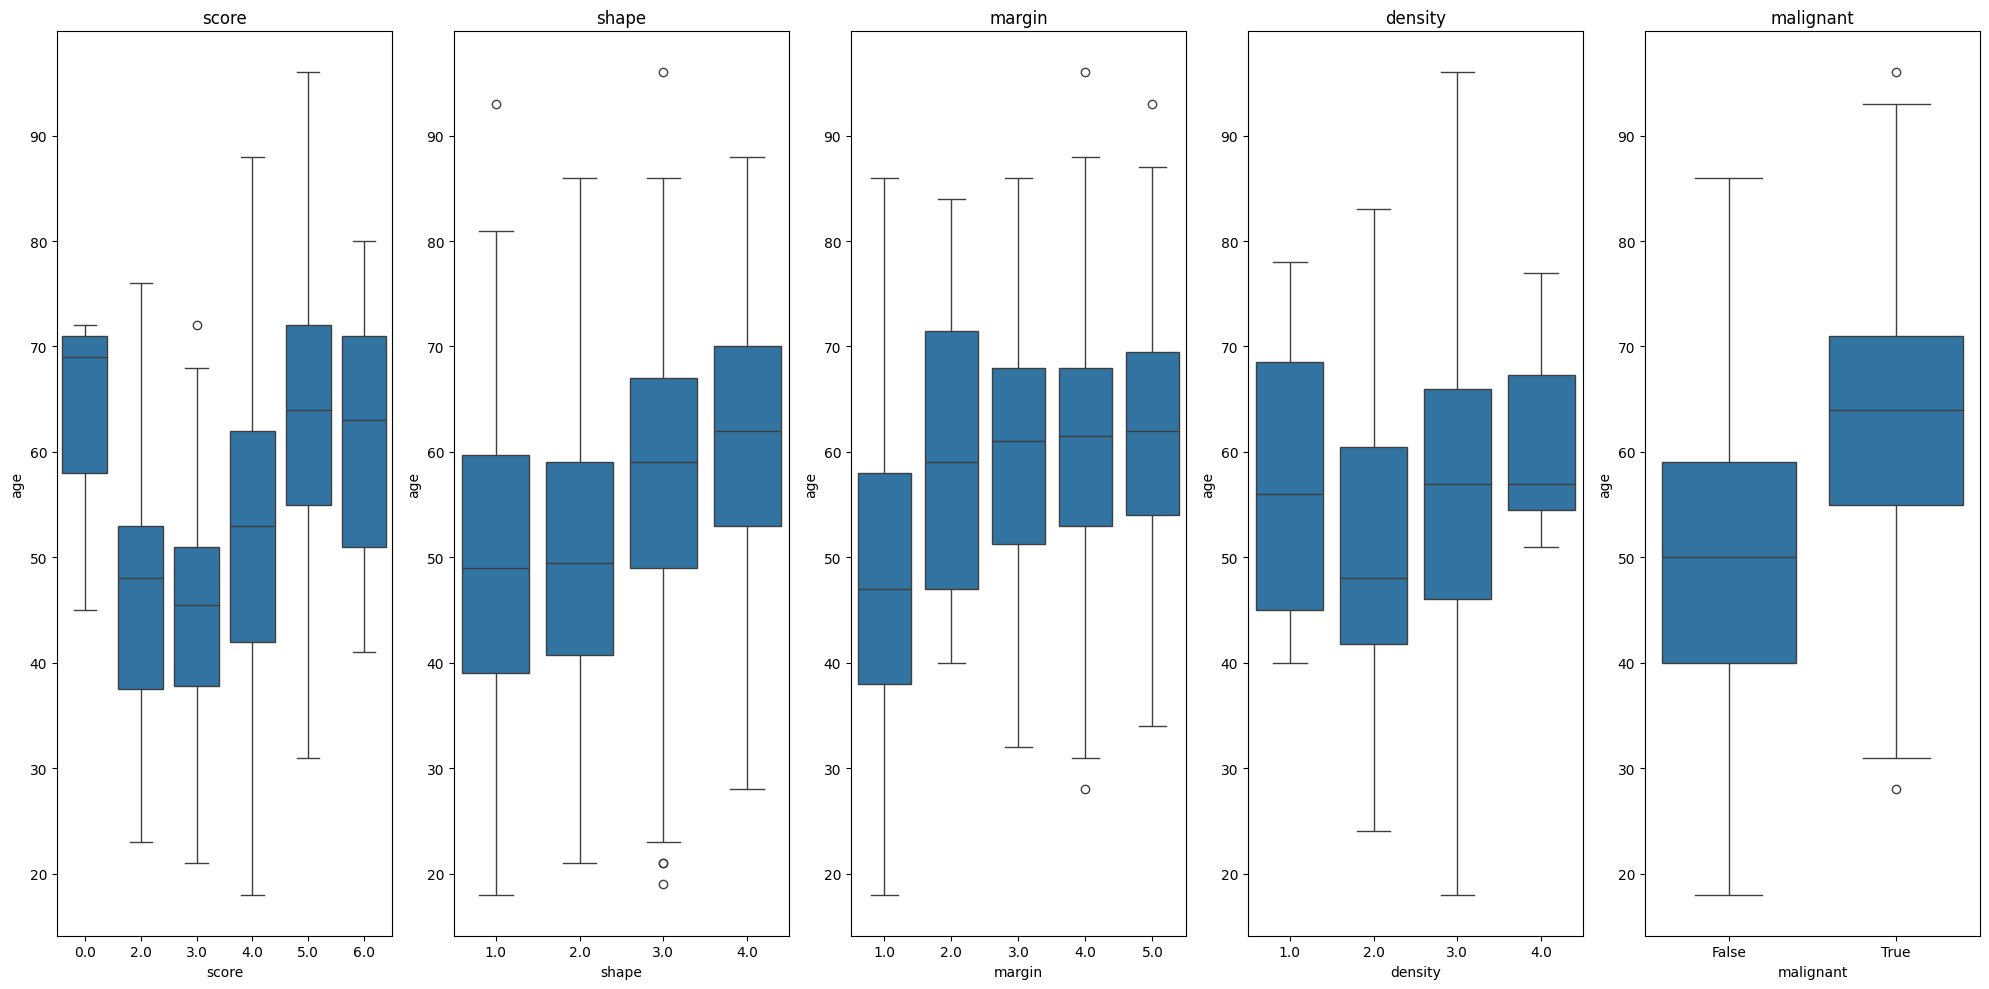

In [7]:
# Creamos la visualización de la edad camaprada con el resto de las variables.
fig, axs = plt.subplots(1, len(df.columns) - 1, figsize=(20, 10))
plot_index = 0

for col in df.columns:
    if col != 'age':
        sns.boxplot(x=col, y='age', data=df, ax=axs[plot_index])
        axs[plot_index].set_title(col)
        plot_index += 1

plt.tight_layout()
plt.show()

Comparamos la distribución de la edad (“age”), que es la única variable continua, con las demás variables categóricas para comprobar si la variable edad es distintiva entre categorías (figura anterior). La variable edad se conservó para realizar diferentes modelos de agrupamiento. Aunque en la clasificación de las lesiones mamarias la edad no es un factor directo, sí se puede relacionar con la densidad mamaria ([Spak et al., 2017](https://www.sciencedirect.com/science/article/pii/S2211568417300013)). Finalmente, se descartaron las variables de evaluación Bi-Rads ("score"), al ser comparable a nuestra variable objetivo, y la variable diagnóstico ("malignant"), que se usó como una forma de evaluar la calidad de los clústeres obtenidos.

Del conjunto de datos se ha eliminado la variable de evaluación BI-RADS, ya que se trata de una variable objetivo. Es decir, con este proyecto se busca una agrupación parecida a esta variable, pero por medios computacionales. La evaluación BI-RADS ([Orel et al., 1999](https://pubs.rsna.org/doi/abs/10.1148/radiology.211.3.r99jn31845)) es una medida estandarizada para evaluar la probabilidad de malignidad de una lesión o tumor en el pecho. Esta evaluación se determina a través de la opinión del especialista luego de analizar las imágenes de las mamografías (entre otras técnicas) para comunicar los resultados de manera sencilla al paciente y a otros profesionales. El conjunto de datos utilizado solo contiene valores BI-RADS del 0 al 6 (la categoría 1 no está presente en el conjunto de datos).

| BI-RADS Category | Description |
| --- | --- |
| 0 | Incomplete (technical issues or incomplete information) |
| 1 | Normal (no abnormalities detected) |
| 2 | Benign (non-cancerous) |
| 3 | Probably benign (but may still be cancerous) |
| 4 | Suspicious (may be cancerous) |
| 5 | Highly suggestive of malignancy (highly likely to be cancerous) |
| 6 | Known biopsy-proven malignancy (confirmed cancer) |
| 7 | Known benign biopsy (confirmed non-cancerous) |

Se ha eliminado de los análisis de agrupamiento la variable "malignant". Esta variable diagnóstica se utilizará para evaluar la precisión de los grupos resultantes de los modelos.

Con las variables restantes ('age', 'shape', 'margin' y 'density') se realizarán los análisis de agrupamiento no supervisado.


In [8]:
# Almacenamos la variable 'malignant' para evaluar el rendimiento del modelo más adelante.
malignant_diagnosis = df['malignant']

# Seleccionamos los datos para agrupar.
cluster_cols = ['age', 'shape', 'margin', 'density']
df_models = df[cluster_cols]
print(df_models)

# Convertimos las variables a variables categóricas
df_models['shape'] = df_models['shape'].astype('object')
df_models['margin'] = df_models['margin'].astype('object')
df_models['density'] = df_models['density'].astype('object')

# Muestramos el conjunto trasformado.
df_models.info()

      age  shape  margin  density
0    45.0    2.0     4.0      3.0
1    69.0    4.0     5.0      3.0
2    58.0    4.0     4.0      3.0
3    72.0    4.0     3.0      3.0
4    71.0    4.0     4.0      3.0
..    ...    ...     ...      ...
954  80.0    4.0     5.0      3.0
955  51.0    4.0     4.0      3.0
956  71.0    4.0     4.0      3.0
957  68.0    4.0     3.0      3.0
958  72.0    4.0     3.0      3.0

[830 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
Index: 830 entries, 0 to 958
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   age      830 non-null    float64
 1   shape    830 non-null    object 
 2   margin   830 non-null    object 
 3   density  830 non-null    object 
dtypes: float64(1), object(3)
memory usage: 32.4+ KB


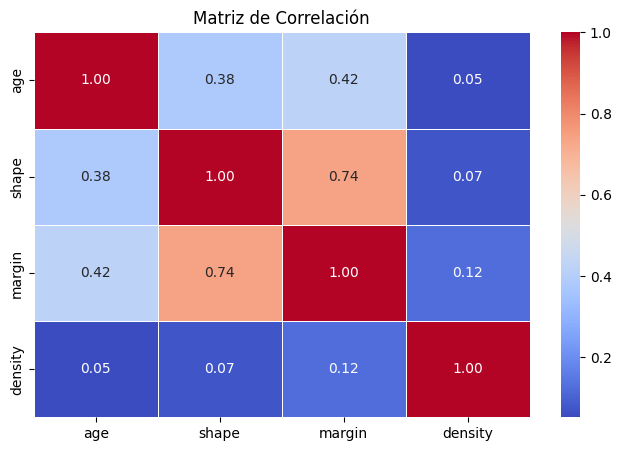

In [10]:
# Calculamos la matriz de correlación
correlation_matrix = df_models.corr()

# Creamos el heatmap de nuestras variables en la matriz de correlación.
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True,  cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación')
plt.show()

En la correlación de las variables se observó que la forma y margen tumoral tienen una correlación de 0,75, mientras que con la edad y la densidad los valores de correlación son menores a 0,45. 
La edad y la densidad mamaria, aunque son factores importantes en el riesgo del cáncer de mama, no son tan determinantes como las características de las lesiones tumorales en cuanto a la forma y el margen para la clasificación en el diagnóstico por mamografía. A medida que aumenta la edad, el riesgo de cáncer de mama también aumenta . Asimismo, una densidad mamaria elevada es un factor de riesgo que puede dificultar la detección de tumores en las mamografías debido a que el tejido denso puede ocultar las lesiones (Boyd et al., 2007; Edwards et al., 2014)[20, 21]. En cambio, las características específicas de las lesiones, forma y márgenes, tienen una relación directa con el riesgo de malignidad y, por lo tanto, son más determinantes en el diagnostico.





La distancia de Gower es una métrica de distancia que puede utilizarse para comparar la similitud entre dos objetos que tienen atributos tanto categóricos como continuos. Es una generalización de la distancia euclidiana que puede utilizarse con datos de tipo mixto ([Gower, 1971](https://www.jstor.org/stable/2528823?origin=crossref)). Usando la esta matriz se consigue emplear e implementar modelos de “punto a punto”.

In [11]:
# Calculamos la matriz de Gower, con la funcion gower_matrix del modulo Gower.
gower_dist = gower_matrix(df_models)
gower_dist

array([[0.        , 0.5769231 , 0.29166666, ..., 0.33333334, 0.57371795,
        0.58653843],
       [0.5769231 , 0.        , 0.28525642, ..., 0.25641027, 0.25320512,
        0.2596154 ],
       [0.29166666, 0.28525642, 0.        , ..., 0.04166667, 0.2820513 ,
        0.2948718 ],
       ...,
       [0.33333334, 0.25641027, 0.04166667, ..., 0.        , 0.2596154 ,
        0.25320512],
       [0.57371795, 0.25320512, 0.2820513 , ..., 0.2596154 , 0.        ,
        0.01282051],
       [0.58653843, 0.2596154 , 0.2948718 , ..., 0.25320512, 0.01282051,
        0.        ]], dtype=float32)

# MODELOS

En este apartado, se implementarán varios modelos de clustering para determinar cuál segrega mejor los grupos en relación de las características tumorales. Se utilizarán los datos transformados anteriormente: Codificación de los datos, la matriz de distancias Gower, datos discretizado y reducción de dimensionalidad.

Se aplicarán métricas para evaluar los cluster. Además, se aplicarán técnicas de reducción de dimensionalidad para implementar y visualizar los cluster.

Por último, con la variable "malignant" que hemos extraído anteriormente, se evaluará cómo los grupos resultantes por los modelos segregan las dolencias malignas y benignas.

## Modelos con componentes UMAP (Datos categóricos, sin la variable edad)

In [12]:
# Copiamos el conjunto df_models sin la variable 'age'.
df_onehot_categorical = df_models.drop('age', axis=1).copy()

# Codificamos las variables categóricas utilizando one-hot encoding.
ohe = OneHotEncoder(sparse_output = False)
encoder_categorical = ohe.fit_transform(df_onehot_categorical)
categorical_encoded = pd.DataFrame(encoder_categorical, columns=ohe.get_feature_names_out(df_onehot_categorical.columns))
categorical_encoded

,shape_1.0,shape_2.0,shape_3.0,shape_4.0,margin_1.0,margin_2.0,margin_3.0,margin_4.0,margin_5.0,density_1.0,density_2.0,density_3.0,density_4.0
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
826,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
827,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
828,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


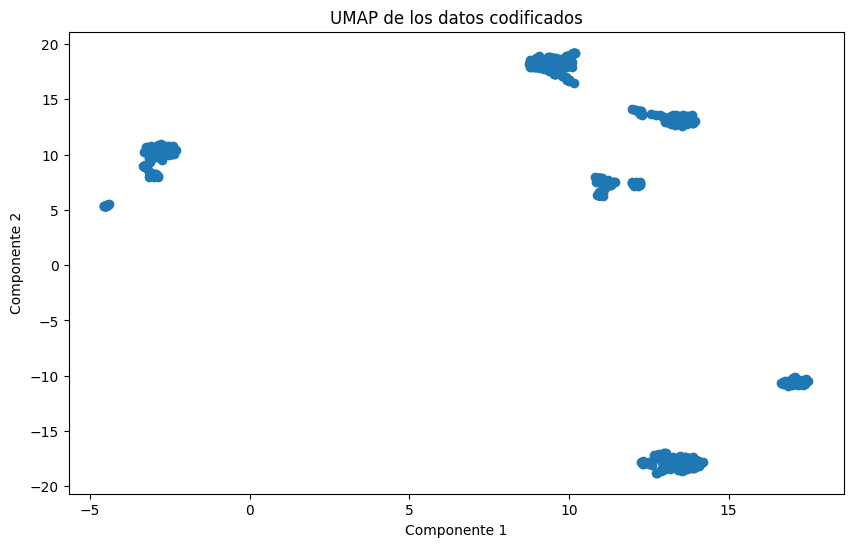

In [13]:
# Aplicar UMAP a los datos codificados.
umap_model = umap.UMAP(n_components=2, random_state = 1)
umap_components = umap_model.fit_transform(categorical_encoded)

# Visualizar los datos reducidos con UMAP.
plt.figure(figsize=(10, 6))
plt.scatter(umap_components[:, 0], umap_components[:, 1])
plt.title('UMAP de los datos codificados')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

Con las variables categóricas codificas (sin tener en cuenta la variable edad), se aplicó la técnica de reducción de dimensionalidad UMAP (Uniform Manifold Approximation and Projection). Esta técnica permitió facilitar la identificación y visualización de patrones en la estructura de nuestros datos. Reduciendo la dimensión a dos componentes principales, se identificó tres zonas en las que se agrupan nuestros datos que podrían representar diferentes subgrupos cada uno con características únicas o compartidas. Esta técnica en combinación con modelos de agrupamiento proporcionó una manera eficaz para analizar y agrupar las características de nuestros datos. 

### K-Means / UMAP (Datos categoricos --> OneHot)

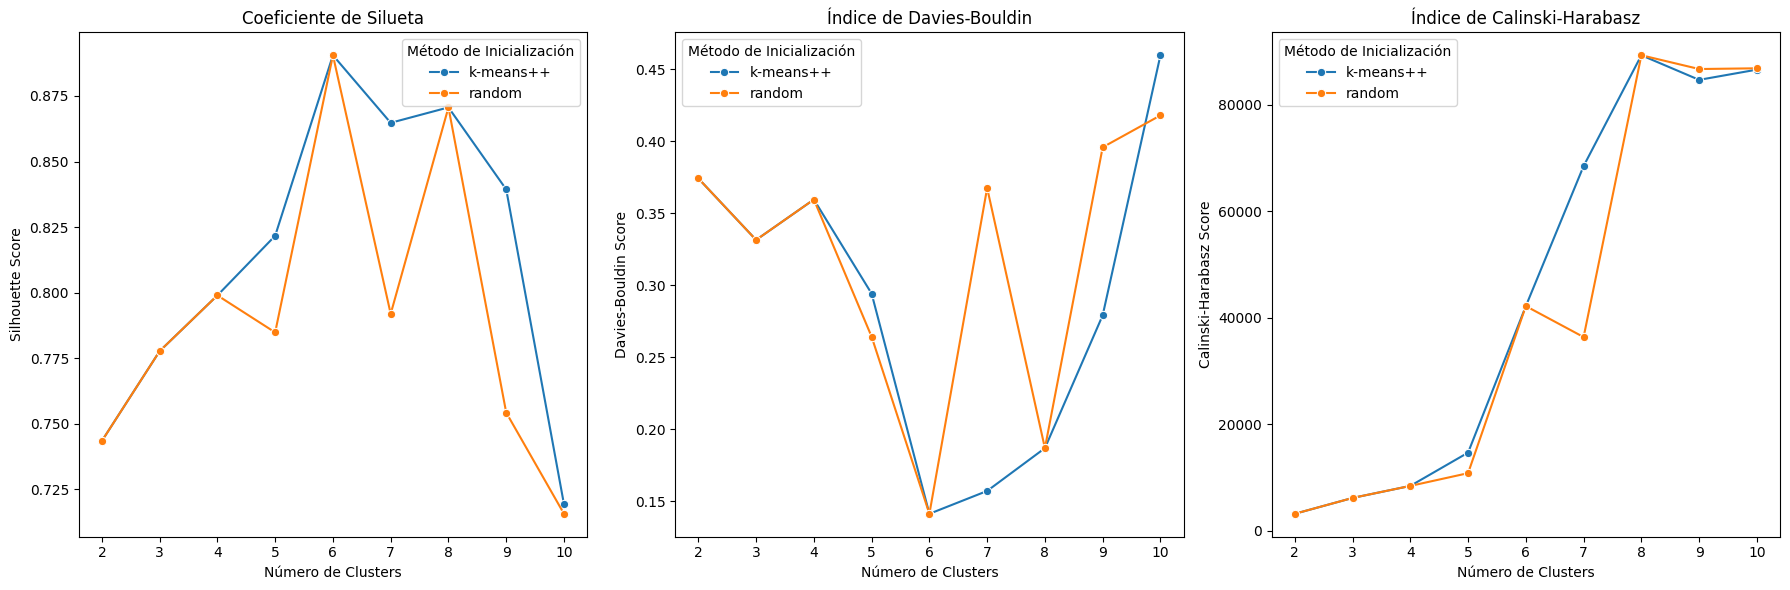

In [14]:
# Aplicamos el algoritmo K-Means en el espacio reducido de UMAP.

# Definimos los rangos de clústers y métodos de inicialización.
n_clusters_range = range(2, 11)
init_methods = ['k-means++', 'random']

# Listas para almacenar las métricas de evaluación.
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

# Aplicamos K-Means para diferentes clusteres y métodos de iniciación.
for n_clusters in n_clusters_range:
    for init_method in init_methods:
        kmeans_model = KMeans(n_clusters=n_clusters, init=init_method, random_state=42)
        kmeans_clusters = kmeans_model.fit_predict(umap_components)
        
        # Calcular métricas de evaluación
        silhouette_avg = silhouette_score(umap_components, kmeans_clusters)
        silhouette_scores.append((n_clusters, init_method, silhouette_avg))
        
        davies_bouldin_avg = davies_bouldin_score(umap_components, kmeans_clusters)
        davies_bouldin_scores.append((n_clusters, init_method, davies_bouldin_avg))
        
        calinski_harabasz_avg = calinski_harabasz_score(umap_components, kmeans_clusters)
        calinski_harabasz_scores.append((n_clusters, init_method, calinski_harabasz_avg))

# Guardamos los resultados en dataframes: 
silhouette_df = pd.DataFrame(silhouette_scores, columns=['Clusters', 'Método de Inicialización', 'Coeficiente de Silueta'])
davies_bouldin_df = pd.DataFrame(davies_bouldin_scores, columns=['Clusters', 'Método de Inicialización', 'Davies-Bouldin Score'])
calinski_harabasz_df = pd.DataFrame(calinski_harabasz_scores, columns=['Clusters', 'Método de Inicialización', 'Índice de Calinski-Harabasz'])

# Graficamos los indices. 
plt.figure(figsize=(18, 6))

# Silhouette Score.
plt.subplot(1, 3, 1)
sns.lineplot(data=silhouette_df, x='Clusters', y='Coeficiente de Silueta', hue='Método de Inicialización', marker='o')
plt.title('Coeficiente de Silueta')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')

# Davies-Bouldin Score.
plt.subplot(1, 3, 2)
sns.lineplot(data=davies_bouldin_df, x='Clusters', y='Davies-Bouldin Score', hue='Método de Inicialización', marker='o')
plt.title('Índice de Davies-Bouldin')
plt.xlabel('Número de Clusters')
plt.ylabel('Davies-Bouldin Score')

# Calinski-Harabasz Score.
plt.subplot(1, 3, 3)
sns.lineplot(data=calinski_harabasz_df, x='Clusters', y='Índice de Calinski-Harabasz', hue='Método de Inicialización', marker='o')
plt.title('Índice de Calinski-Harabasz')
plt.xlabel('Número de Clusters')
plt.ylabel('Calinski-Harabasz Score')

plt.tight_layout()
plt.show()

Índice de Davies-Bouldin: 0.15702847894301894
Índice de Calinski-Harabasz: 68486.80202076309
Coeficiente de Silueta: 0.86476684


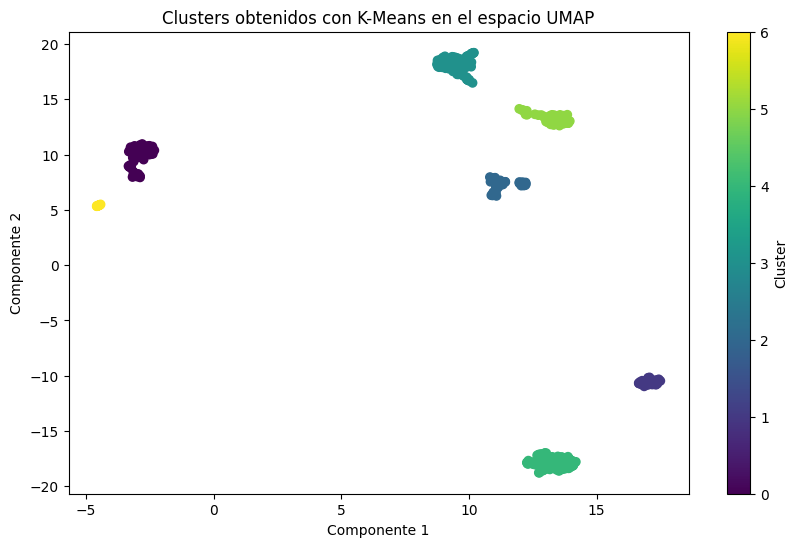

In [107]:
# Visualizar los clusters obtenidos con K-Means, para k = 7:

kmeans_model = KMeans(n_clusters=7, init='k-means++', random_state=42)
kmeans_clusters = kmeans_model.fit_predict(umap_components)

# índice de Davies-Bouldin
db_index = davies_bouldin_score(umap_components, kmeans_clusters)

# índice de Calinski-Harabasz
ch_index = calinski_harabasz_score(umap_components, kmeans_clusters)

# coeficiente de silueta
silhouette_avg = silhouette_score(umap_components, kmeans_clusters)

# Imprimimos los resultados
print("Índice de Davies-Bouldin:", db_index)
print("Índice de Calinski-Harabasz:", ch_index)
print("Coeficiente de Silueta:", silhouette_avg)

plt.figure(figsize=(10, 6))
plt.scatter(umap_components[:, 0], umap_components[:, 1], c=kmeans_clusters, cmap='viridis')
plt.title('Clusters obtenidos con K-Means en el espacio UMAP')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.colorbar(label='Cluster')
plt.show()

Las componentes resultantes de la reducción de dimensionalidad UMAP se aplicaron en el modelo de agrupamiento K-Means. Para determinar el número de clústeres optimo se exploró, en un rango de dos a diez clústeres con diferentes métodos de iniciación (“k-means++” y “random”), distintos índices de validación.
Tras examinar los índices de evaluación y analizar la distribución visual de clústeres, se determinó que, aun no siendo los valores óptimos de evaluación comparado a otro valor de clústeres, el número de clústeres que mejor se ajustó a la naturaleza de nuestros datos fue siete (k = 7) con el método de iniciación “k-means++”.


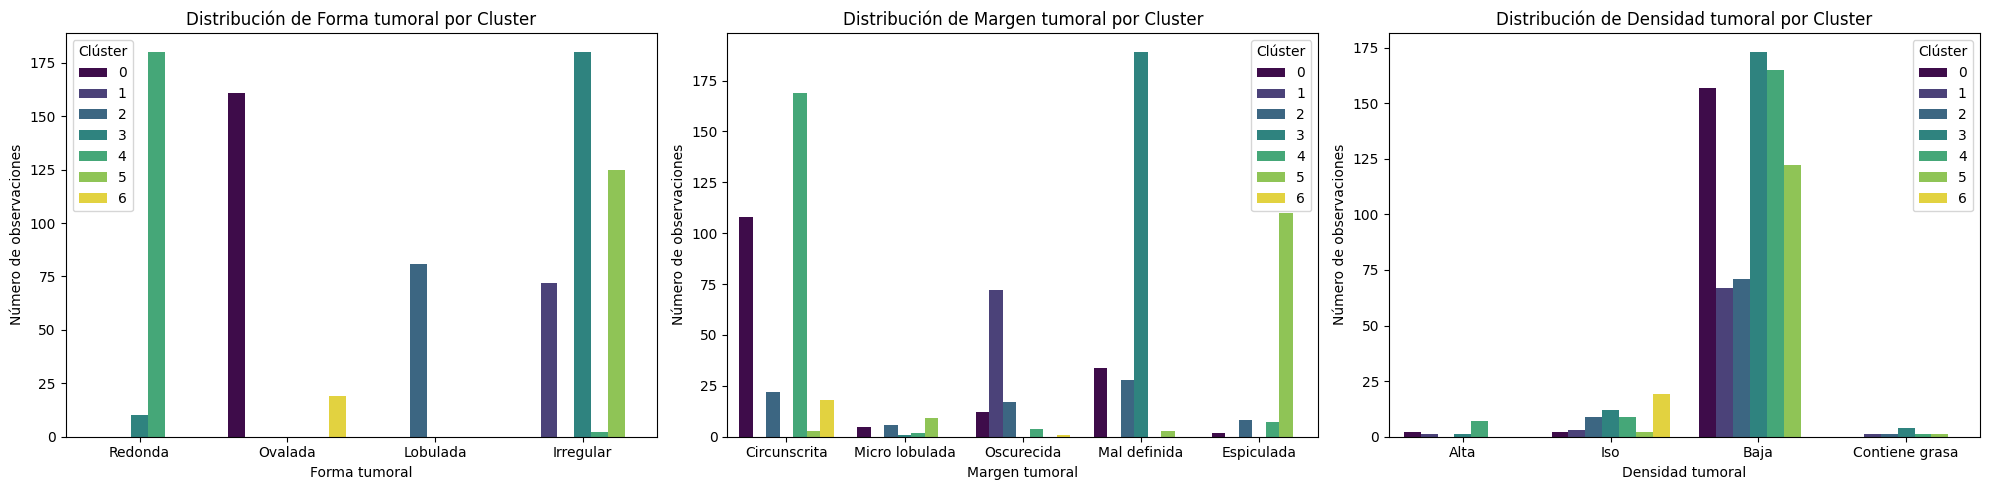

In [108]:
df_kmeans_eval = df_models.copy()

# Para evaluar el modelo introducimos los clústeres y la variables diagnósis al dataframe: 
df_kmeans_eval['Cluster'] = kmeans_clusters
df_kmeans_eval['Malignant'] = malignant_diagnosis

# Mapeos de  categorías
shape_mapping = {1: 'Redonda', 2: 'Ovalada', 3: 'Lobulada', 4: 'Irregular'}
margin_mapping = {1: 'Circunscrita', 2: 'Micro lobulada', 3: 'Oscurecida', 4: 'Mal definida', 5: 'Espiculada'}
density_mapping = {1: 'Alta', 2: 'Iso', 3: 'Baja', 4: 'Contiene grasa'}

# Función auxiliar para mapear etiquetas
def map_labels(labels, mapping):
    mapped_labels = []
    for label in labels:
        try:
            int_label = int(float(label.get_text()))  # Convertir a float primero y luego a int
            mapped_labels.append(mapping.get(int_label, label.get_text()))
        except ValueError:
            mapped_labels.append(label.get_text())  # Mantener la etiqueta original si no se puede convertir
    return mapped_labels

# Figuras y ejes para los subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Distribución de 'Shape' por cluster
sns.countplot(x='shape', hue='Cluster', data=df_kmeans_eval, palette='viridis', ax=axs[0])
axs[0].set_title('Distribución de Forma tumoral por Cluster')
axs[0].set_xlabel('Forma tumoral')
axs[0].set_ylabel('Número de observaciones')
axs[0].legend(title='Clúster')
axs[0].set_xticklabels(map_labels(axs[0].get_xticklabels(), shape_mapping))

# Distribución de 'Margin' por cluster
sns.countplot(x='margin', hue='Cluster', data=df_kmeans_eval, palette='viridis', ax=axs[1])
axs[1].set_title('Distribución de Margen tumoral por Cluster')
axs[1].set_xlabel('Margen tumoral')
axs[1].set_ylabel('Número de observaciones')
axs[1].legend(title='Clúster')
axs[1].set_xticklabels(map_labels(axs[1].get_xticklabels(), margin_mapping))

# Distribución de 'Density' por cluster
sns.countplot(x='density', hue='Cluster', data=df_kmeans_eval, palette='viridis', ax=axs[2])
axs[2].set_title('Distribución de Densidad tumoral por Cluster')
axs[2].set_xlabel('Densidad tumoral')
axs[2].set_ylabel('Número de observaciones')
axs[2].legend(title='Clúster')
axs[2].set_xticklabels(map_labels(axs[2].get_xticklabels(), density_mapping))

# Ajustar los subplots
plt.tight_layout()

# Mostrar los gráficos
plt.show()

En la distribución de las características por clúster, se observó que, los grupos compartían características. Para la forma tumoral los grupos se segregaron de forma más definida, los clústeres 0 y 6 comparten la característica ovalada. Los clústeres 1, 3 y 5 se concentran en la forma irregular, con una presencia mínima del clúster 4. El clúster 4 se concentra en la forma redonda, donde también se observan unas pocas observaciones del clúster 3. El clúster 2 solo se observó para la forma lobulada. 
Para el margen tumoral, se observó una segregación más irregular, ya que los clústeres comparten más características entre sí. En cuanto al margen circunscrito, solo están presentes los clústeres 0, 2, 4, 5 y 6. En el margen microlobulado, a pesar de tener un número bajo de observaciones, se presentaron todos los clústeres excepto el clúster 1. En el margen oscurecido, están presentes los clústeres 0, 1, 2, 4 y 6. Para el margen mal definido, no están presentes los clústeres 0, 2, 3, 5 y 6. Por último, el margen espiculado presenta los clústeres 0, 2, 4 y 5.
Para la característica densidad, se destacó que los clústeres se concentraron en la característica de densidad baja, con excepción del clúster 6, que está ausente en esta característica y solo está presente en la característica de densidad Iso. 


Malignant counts by cluster:
Malignant  False  True 
Cluster                
0            130     31
1             16     56
2             39     42
3             43    147
4            156     26
5             24    101
6             19      0
Proporciones de casos malignos por cluster:
Cluster
0    0.192547
1    0.777778
2    0.518519
3    0.773684
4    0.142857
5    0.808000
6    0.000000
Name: Malignant, dtype: float64


<Figure size 1000x600 with 0 Axes>

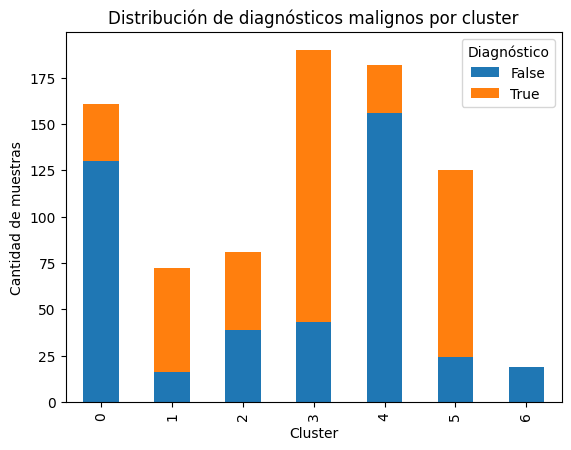

In [109]:
# Contamos el número de diagnósticos malignos por clúster
print("Malignant counts by cluster:")
print(df_kmeans_eval.groupby(['Cluster', 'Malignant']).size().unstack(fill_value=0))

# Agrupamos por número de clúster y calcular la proporción de casos malignos en cada clúster.
malignant_proportions = df_kmeans_eval.groupby('Cluster')['Malignant'].mean()

# Imprimimos las proporciones de casos malignos por clúster.
print("Proporciones de casos malignos por cluster:")
print(malignant_proportions)

# Histogramas de los clústeres por diagnóstico.
plt.figure(figsize=(10, 6))
df_kmeans_eval.groupby(['Cluster', 'Malignant']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Distribución de diagnósticos malignos por cluster')
plt.xlabel('Cluster')
plt.ylabel('Cantidad de muestras')
plt.legend(title='Diagnóstico')
plt.show()

El porcentaje de casos malignos por grupo fue el siguiente: el clúster 0 presentó un 20% de casos malignos, el clúster 1 un 77%, el clúster 2 un 52%, el clúster 3 un 77%, el clúster 4 un 14%, el clúster 5 un 80% y el clúster 6 un 0%.

# Modelos con datos mixtos / datos categoricos

### K-Modes

Implementamos K-Modes con las variables categóricas y las variables continuas discretizadas.

In [66]:
# Copiamos el dataframe de la implementacion de los modelos:
df_kmodes = df_models.copy()

# Se discretiza la edad en rangos de 10:
bins = [18, 20, 30, 40, 50, 60, 70, 80, 90, 100] 
labels = ['18-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']  
df_kmodes['Age_group'] = pd.cut(df_kmodes['age'], bins=bins, labels=labels, right=False).astype('object')
df_kmodes.drop(('age'), axis = 1, inplace = True)

# Condificamos los grupos de edad
le = LabelEncoder()
df_kmodes['Age_group'] = le.fit_transform(df_kmodes[['Age_group']]).astype("object")

# Se elimnó la variable edad ya que nos da valores peores que mantenerla.
df_kmodes.drop(('Age_group'), axis = 1, inplace = True)  
print(df_kmodes.info())

<class 'pandas.core.frame.DataFrame'>
Index: 830 entries, 0 to 958
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   shape    830 non-null    object
 1   margin   830 non-null    object
 2   density  830 non-null    object
dtypes: object(3)
memory usage: 25.9+ KB
None


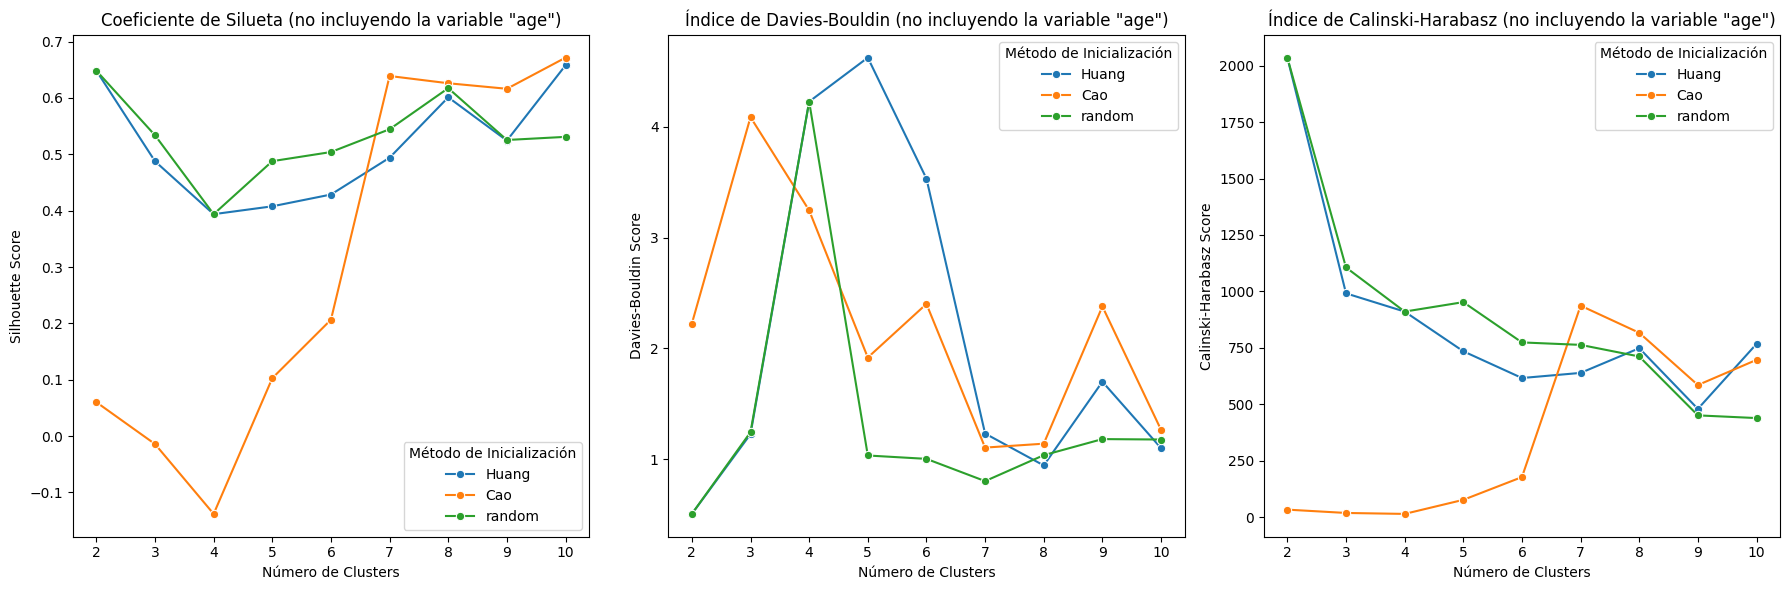

In [67]:
init_methods = ['Huang', 'Cao', 'random']
n_clusters_range = range(2, 11)

# Listas para almacenar las métricas de evaluación
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

# KModes para diferentes clústeres y métodos de iniciación.
for init_method in init_methods:
    for n_clusters in n_clusters_range:
        kmodes_model = KModes(n_clusters=n_clusters, init=init_method, n_init=10, random_state=42)
        clusters_kmodes = kmodes_model.fit_predict(df_kmodes)
        
        # Calcular métricas de evaluación
        silhouette_avg = silhouette_score(df_kmodes, clusters_kmodes)
        silhouette_scores.append((n_clusters, init_method, silhouette_avg))
        
        davies_bouldin_avg = davies_bouldin_score(df_kmodes, clusters_kmodes)
        davies_bouldin_scores.append((n_clusters, init_method, davies_bouldin_avg))
        
        calinski_harabasz_avg = calinski_harabasz_score(df_kmodes, clusters_kmodes)
        calinski_harabasz_scores.append((n_clusters, init_method, calinski_harabasz_avg))

# Convertir los resultados a DataFrames
silhouette_df = pd.DataFrame(silhouette_scores, columns=['Clusters', 'Método de Inicialización', 'Coeficiente de Silueta'])
davies_bouldin_df = pd.DataFrame(davies_bouldin_scores, columns=['Clusters', 'Método de Inicialización', 'Davies-Bouldin Score'])
calinski_harabasz_df = pd.DataFrame(calinski_harabasz_scores, columns=['Clusters', 'Método de Inicialización', 'Índice de Calinski-Harabasz'])

# Graficar las métricas
plt.figure(figsize=(18, 6))

# Silhouette Score
plt.subplot(1, 3, 1)
sns.lineplot(data=silhouette_df, x='Clusters', y='Coeficiente de Silueta', hue='Método de Inicialización', marker='o')
plt.title('Coeficiente de Silueta (no incluyendo la variable "age")')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')

# Davies-Bouldin Score
plt.subplot(1, 3, 2)
sns.lineplot(data=davies_bouldin_df, x='Clusters', y='Davies-Bouldin Score', hue='Método de Inicialización', marker='o')
plt.title('Índice de Davies-Bouldin (no incluyendo la variable "age")')
plt.xlabel('Número de Clusters')
plt.ylabel('Davies-Bouldin Score')

# Calinski-Harabasz Score
plt.subplot(1, 3, 3)
sns.lineplot(data=calinski_harabasz_df, x='Clusters', y='Índice de Calinski-Harabasz', hue='Método de Inicialización', marker='o')
plt.title('Índice de Calinski-Harabasz (no incluyendo la variable "age")')
plt.xlabel('Número de Clusters')
plt.ylabel('Calinski-Harabasz Score')

plt.tight_layout()
plt.show()

Se utilizaron las componentes categóricas del conjunto de datos para implementar el algoritmo K-Modes. En un primer momento se exploró la posibilidad de usar la variable continua edad (“age”), para usar esta variable se discretizó en intervalos de 10 años y estos intervalos se transformaron a valores numéricos categóricos mediante la codificación de etiquetas. Para determinar el número de clústeres optimo se utilizó un rango de clústeres (de 2 a 10) con distintos tipos de iniciación para el algoritmo (“Huang”, “Cao” y “random”)

In [71]:
# Implementamos el modelo Kmodes con los parametros elegidos: 
kmodes_model = KModes(n_clusters=2, init='random', n_init=10, random_state=42)
clusters_kmodes = kmodes_model.fit_predict(df_kmodes)

# índice de Davies-Bouldin
db_index = davies_bouldin_score(df_kmodes, clusters_kmodes)

# índice de Calinski-Harabasz
ch_index = calinski_harabasz_score(df_kmodes, clusters_kmodes)

# coeficiente de silueta
silhouette_avg = silhouette_score(df_kmodes, clusters_kmodes)

# Imprimimos los resultados
print("Índice de Davies-Bouldin:", db_index)
print("Índice de Calinski-Harabasz:", ch_index)
print("Coeficiente de Silueta:", silhouette_avg)

Índice de Davies-Bouldin: 0.5051431704829833
Índice de Calinski-Harabasz: 2035.6023520110955
Coeficiente de Silueta: 0.6483845612066804


En base a los índices obtenidos se optó por implementar el modelo sin incluir la variable edad (“age”), con el método de iniciación “random” y estableciendo el número de clústeres a 2 (k =2). Los valores de los índices indican que los clústeres pueden estar cohesionados y relativamente bien separados, aunque los grupos comparten alguna característica. 

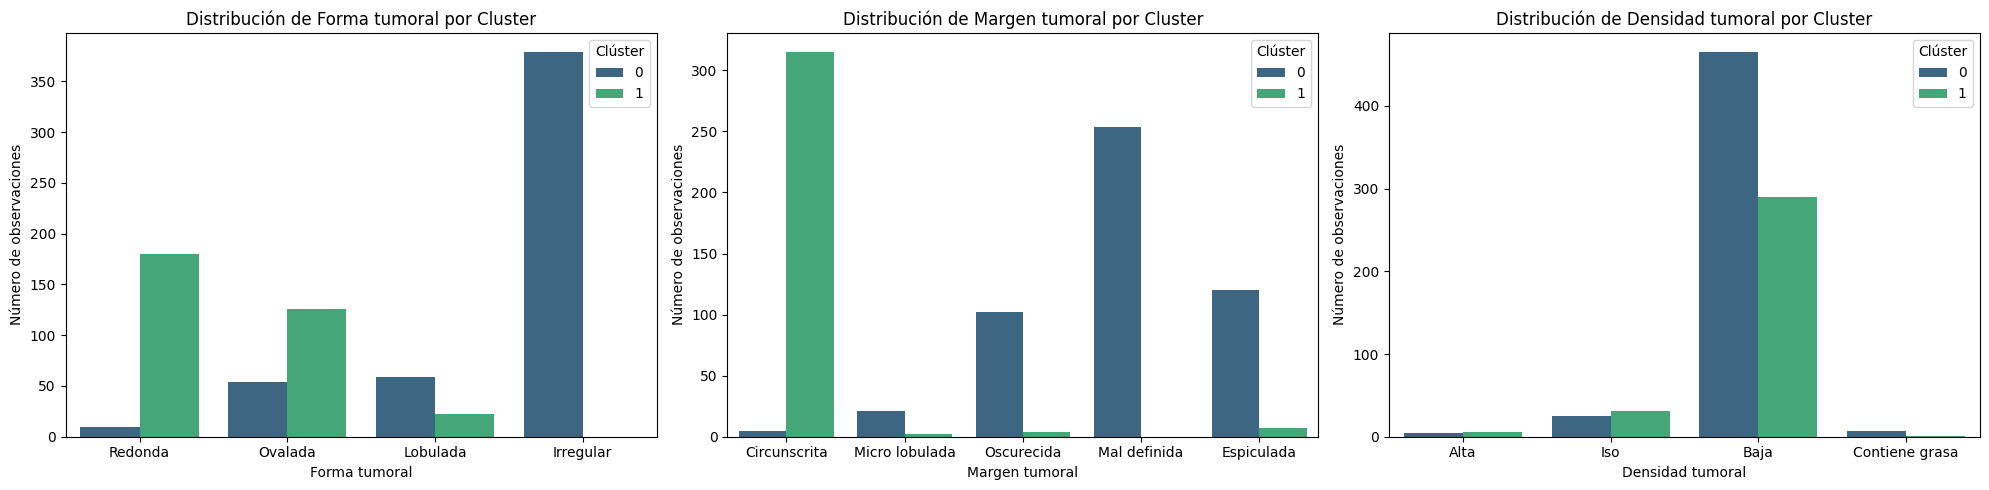

In [75]:
# Para evaluar el modelo introducimos los clústeres y la variables diagnósis al dataframe:
df_kmodes_eval = df_kmodes.copy()

df_kmodes_eval['Cluster'] = clusters_kmodes
df_kmodes_eval['Malignant'] = malignant_diagnosis

# Mapeos de las categorías
shape_mapping = {1: 'Redonda', 2: 'Ovalada', 3: 'Lobulada', 4: 'Irregular'}
margin_mapping = {1: 'Circunscrita', 2: 'Micro lobulada', 3: 'Oscurecida', 4: 'Mal definida', 5: 'Espiculada'}
density_mapping = {1: 'Alta', 2: 'Iso', 3: 'Baja', 4: 'Contiene grasa'}

# mapeamos las etiquetas
def map_labels(labels, mapping):
    mapped_labels = []
    for label in labels:
        try:
            int_label = int(float(label.get_text()))  
            mapped_labels.append(mapping.get(int_label, label.get_text()))
        except ValueError:
            mapped_labels.append(label.get_text())
    return mapped_labels

# Figuras:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Distribución de 'Shape' por cluster
sns.countplot(x='shape', hue='Cluster', data=df_kmodes_eval, palette='viridis', ax=axs[0])
axs[0].set_title('Distribución de Forma tumoral por Cluster')
axs[0].set_xlabel('Forma tumoral')
axs[0].set_ylabel('Número de observaciones')
axs[0].legend(title='Clúster')
axs[0].set_xticklabels(map_labels(axs[0].get_xticklabels(), shape_mapping))

# Distribución de 'Margin' por cluster
sns.countplot(x='margin', hue='Cluster', data=df_kmodes_eval, palette='viridis', ax=axs[1])
axs[1].set_title('Distribución de Margen tumoral por Cluster')
axs[1].set_xlabel('Margen tumoral')
axs[1].set_ylabel('Número de observaciones')
axs[1].legend(title='Clúster')
axs[1].set_xticklabels(map_labels(axs[1].get_xticklabels(), margin_mapping))

# Distribución de 'Density' por cluster
sns.countplot(x='density', hue='Cluster', data=df_kmodes_eval, palette='viridis', ax=axs[2])
axs[2].set_title('Distribución de Densidad tumoral por Cluster')
axs[2].set_xlabel('Densidad tumoral')
axs[2].set_ylabel('Número de observaciones')
axs[2].legend(title='Clúster')
axs[2].set_xticklabels(map_labels(axs[2].get_xticklabels(), density_mapping))

# Ajustar los subplots
plt.tight_layout()

# Mostrar los gráficos
plt.show()

Las características tumorales se distribuyeron en dos clústeres, y se observó que, aunque ambos clústeres compartían características, se agrupaban ciertas características más un clúster que en otro, menos para la densidad tumoral (“density”), que ambos grupos comparten mayoritariamente la característica de densidad baja. 

El clúster 0 presentó características más relacionadas con dolencias malignas, como la formar irregular, donde las observaciones de este clúster se concentran, así como márgenes tumorales poco definidos. Al contrario, el clúster 1, presentó formas más definidas y esféricas (ovaladas y lobuladas), y el margen tumoral que presenta este grupo es sobre todo circunscrito o bien definido, características que suelen presentar los tumores de índole benigno.

Malignant counts by cluster:
Malignant  False  True 
Cluster                
0            142    360
1            285     43
Proporciones de casos malignos por cluster:
Cluster
0    0.717131
1    0.131098
Name: Malignant, dtype: float64


<Figure size 1000x600 with 0 Axes>

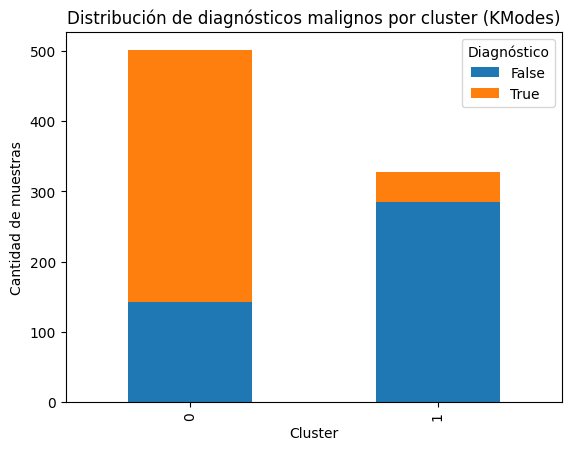

In [76]:
# Contamos el número de diagnósticos malignos por clúster
malignant_proportions = df_kmodes_eval.groupby('Cluster')['Malignant'].mean()

# Agrupamos por número de clúster y calcular la proporción de casos malignos en cada clúster.
print("Malignant counts by cluster:")
print(df_kmodes_eval.groupby(['Cluster', 'Malignant']).size().unstack(fill_value=0))

# Imprimimos las proporciones de casos malignos por clúster.
print("Proporciones de casos malignos por cluster:")
print(malignant_proportions)

# Histogramas de los clústeres por diagnóstico.
plt.figure(figsize=(10, 6))
df_kmodes_eval.groupby(['Cluster', 'Malignant']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Distribución de diagnósticos malignos por cluster (KModes)')
plt.xlabel('Cluster')
plt.ylabel('Cantidad de muestras')
plt.legend(title='Diagnóstico')
plt.show()

Atendiendo a la distribución de los diagnósticos se puede concluir que el clúster 0 concentra en gran medida las características malignas, con un 72% de las observaciones con diagnostico maligno. Y el clúster 1 aúna las características benignas, teniendo solo una incidencia de malignidad del 13%. Aun así, aunque este algoritmo puede segregar características malignas de las benignas, no se consiguió un clúster que solo tuviera observaciones malignas o benignas, es decir, hay características que se solapan en los clústeres.

### K-Prototypes

En este apartado vamos a aplicar el algoritmo K-prototypes que es una extensión del K-Means que permite manejar tanto datos numéricos como categóricos.

In [29]:
df_kprototypes = df_models.copy()
print(df_kprototypes.info())

<class 'pandas.core.frame.DataFrame'>
Index: 830 entries, 0 to 958
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   age      830 non-null    float64
 1   shape    830 non-null    object 
 2   margin   830 non-null    object 
 3   density  830 non-null    object 
dtypes: float64(1), object(3)
memory usage: 32.4+ KB
None


In [30]:
# Columnas categoricas:
categorical_cols = ['shape', 'margin', 'density']
# Lista para almacenar los índices de las columnas categóricas
categorical_indexes = []

# Obtenemos el índice de la columna 'c' en el DataFrame df_kprototypes y lo añade a categorical_indexes
for c in categorical_cols:
    categorical_indexes.append(df_kprototypes.columns.get_loc(c))

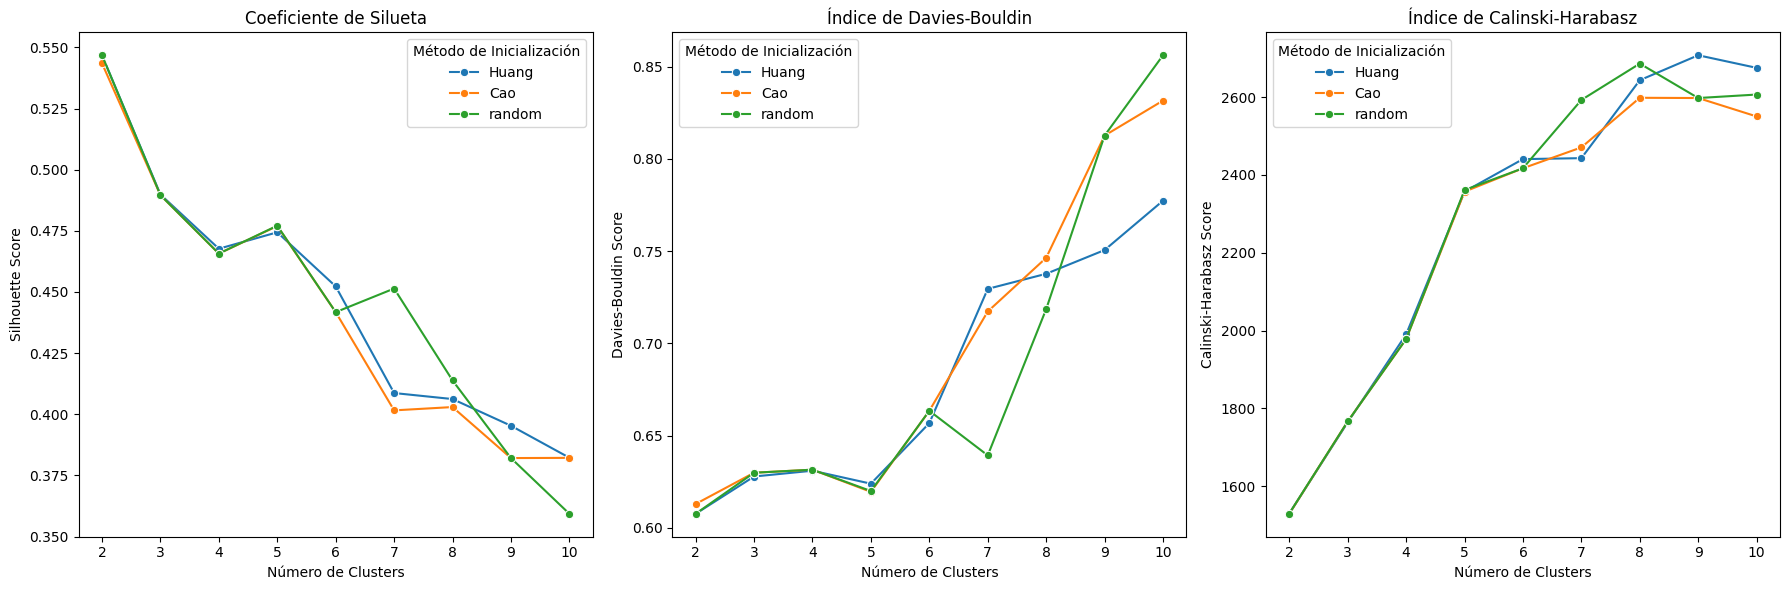

In [42]:
init_methods = ['Huang', 'Cao', 'random']
n_clusters_range = range(2, 11)

# Listas para almacenar las métricas de evaluación
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

# Aplicar KPrototypes para diferentes configuraciones
for init_method in init_methods:
    for n_clusters in n_clusters_range:
        kproto = KPrototypes(n_clusters=n_clusters, init=init_method, n_init=10, random_state=42)
        clusters_kproto = kproto.fit_predict(df_kprototypes, categorical=categorical_indexes)
        
        # Calcular métricas de evaluación
        silhouette_avg = silhouette_score(df_kprototypes, clusters_kproto)
        silhouette_scores.append((n_clusters, init_method, silhouette_avg))
        
        davies_bouldin_avg = davies_bouldin_score(df_kprototypes, clusters_kproto)
        davies_bouldin_scores.append((n_clusters, init_method, davies_bouldin_avg))
        
        calinski_harabasz_avg = calinski_harabasz_score(df_kprototypes, clusters_kproto)
        calinski_harabasz_scores.append((n_clusters, init_method, calinski_harabasz_avg))

# Guardamos los resultados a DataFrames
silhouette_df = pd.DataFrame(silhouette_scores, columns=['Clusters', 'Método de Inicialización', 'Coeficiente de Silueta'])
davies_bouldin_df = pd.DataFrame(davies_bouldin_scores, columns=['Clusters', 'Método de Inicialización', 'Davies-Bouldin Score'])
calinski_harabasz_df = pd.DataFrame(calinski_harabasz_scores, columns=['Clusters', 'Método de Inicialización', 'Índice de Calinski-Harabasz'])

# Graficas
plt.figure(figsize=(18, 6))

# Silhouette Score
plt.subplot(1, 3, 1)
sns.lineplot(data=silhouette_df, x='Clusters', y='Coeficiente de Silueta', hue='Método de Inicialización', marker='o')
plt.title('Coeficiente de Silueta')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')

# Davies-Bouldin Score
plt.subplot(1, 3, 2)
sns.lineplot(data=davies_bouldin_df, x='Clusters', y='Davies-Bouldin Score', hue='Método de Inicialización', marker='o')
plt.title('Índice de Davies-Bouldin')
plt.xlabel('Número de Clusters')
plt.ylabel('Davies-Bouldin Score')

# Calinski-Harabasz Score
plt.subplot(1, 3, 3)
sns.lineplot(data=calinski_harabasz_df, x='Clusters', y='Índice de Calinski-Harabasz', hue='Método de Inicialización', marker='o')
plt.title('Índice de Calinski-Harabasz')
plt.xlabel('Número de Clusters')
plt.ylabel('Calinski-Harabasz Score')

plt.tight_layout()
plt.show()

El algoritmo K-Prototypes nos permitió manejar las variables categóricas y numéricas en un mismo algoritmo sin la necesidad de codificar o transformar las variables. Como en anteriores modelos, se calcularon y se evaluaron los índices de evaluación para un rango de clústeres (de 2 a 10) con diferentes métodos de iniciación (“Huang”, “Cao” y “random”).
Atendiendo a los valores de evaluación y a una exploración visual se estableció que el número óptimo de clúster fue 5 (k=5).


In [94]:
# Modelo implementado con k = 5 y metodod de iniciacion 'Huang'
kproto = KPrototypes(n_clusters = 5, init = 'Huang', n_init = 10, random_state = 42)
kproto.fit_predict(df_kprototypes, categorical = categorical_indexes)
cluster_kproto = kproto.labels_

# índice de Davies-Bouldin
db_index = davies_bouldin_score(df_kprototypes, cluster_kproto)

# índice de Calinski-Harabasz
ch_index = calinski_harabasz_score(df_kprototypes, cluster_kproto)

# coeficiente de silueta
silhouette_avg = silhouette_score(df_kprototypes, cluster_kproto)

# Imprimimos los resultados
print("Índice de Davies-Bouldin:", db_index)
print("Índice de Calinski-Harabasz:", ch_index)
print("Coeficiente de Silueta:", silhouette_avg)


Índice de Davies-Bouldin: 0.6239995858692428
Índice de Calinski-Harabasz: 2357.3289973335864
Coeficiente de Silueta: 0.47439719895323074


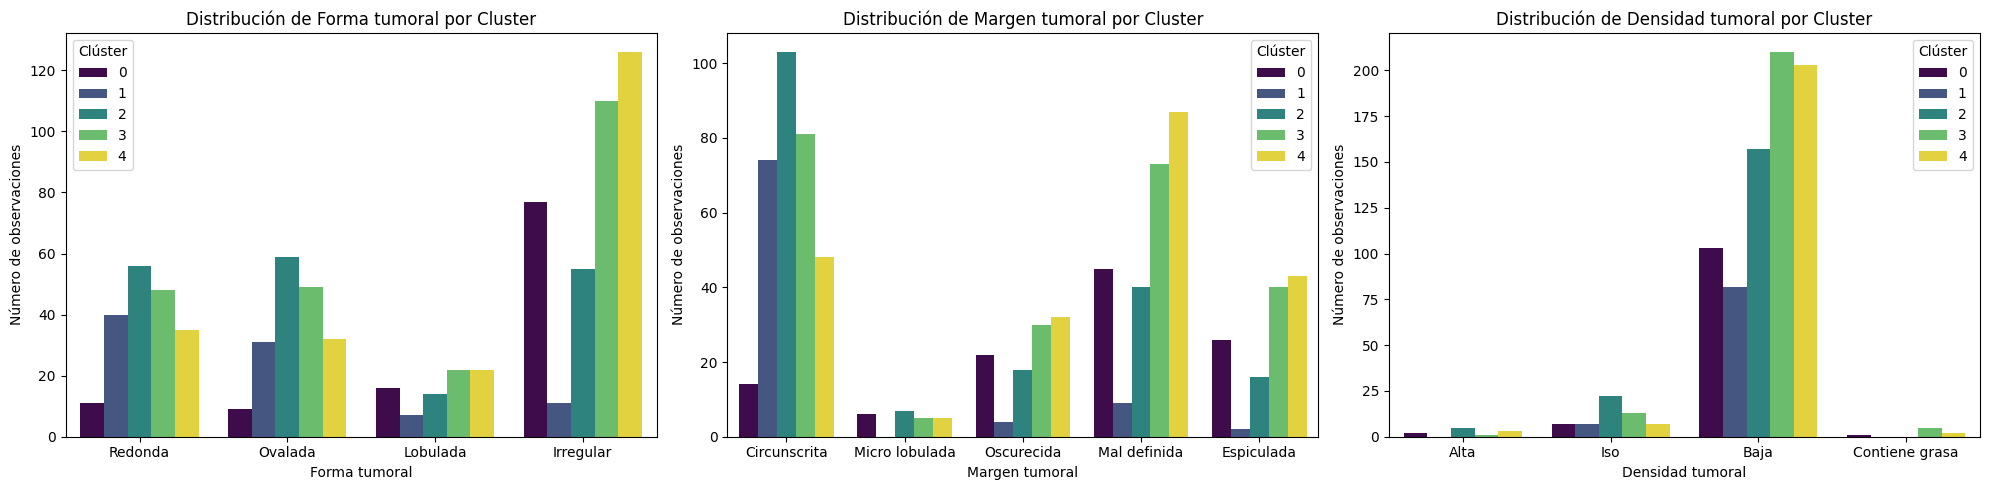

In [95]:
# Para evaluar el modelo introducimos los clústeres y la variables diagnósis al dataframe:
df_kprototypes_eval = df_kprototypes.copy()
df_kprototypes_eval['Cluster'] = cluster_kproto
df_kprototypes_eval['Malignant'] = malignant_diagnosis

# Mapeos de las categorías
shape_mapping = {1: 'Redonda', 2: 'Ovalada', 3: 'Lobulada', 4: 'Irregular'}
margin_mapping = {1: 'Circunscrita', 2: 'Micro lobulada', 3: 'Oscurecida', 4: 'Mal definida', 5: 'Espiculada'}
density_mapping = {1: 'Alta', 2: 'Iso', 3: 'Baja', 4: 'Contiene grasa'}

# mapear etiquetas
def map_labels(labels, mapping):
    mapped_labels = []
    for label in labels:
        try:
            int_label = int(float(label.get_text()))  # Convertir a float primero y luego a int
            mapped_labels.append(mapping.get(int_label, label.get_text()))
        except ValueError:
            mapped_labels.append(label.get_text())  # Mantener la etiqueta original si no se puede convertir
    return mapped_labels

# Figuras:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Distribución de 'Shape' por cluster
sns.countplot(x='shape', hue='Cluster', data=df_kprototypes_eval, palette='viridis', ax=axs[0])
axs[0].set_title('Distribución de Forma tumoral por Cluster')
axs[0].set_xlabel('Forma tumoral')
axs[0].set_ylabel('Número de observaciones')
axs[0].legend(title='Clúster')
axs[0].set_xticklabels(map_labels(axs[0].get_xticklabels(), shape_mapping))

# Distribución de 'Margin' por cluster
sns.countplot(x='margin', hue='Cluster', data=df_kprototypes_eval, palette='viridis', ax=axs[1])
axs[1].set_title('Distribución de Margen tumoral por Cluster')
axs[1].set_xlabel('Margen tumoral')
axs[1].set_ylabel('Número de observaciones')
axs[1].legend(title='Clúster')
axs[1].set_xticklabels(map_labels(axs[1].get_xticklabels(), margin_mapping))

# Distribución de 'Density' por cluster
sns.countplot(x='density', hue='Cluster', data=df_kprototypes_eval, palette='viridis', ax=axs[2])
axs[2].set_title('Distribución de Densidad tumoral por Cluster')
axs[2].set_xlabel('Densidad tumoral')
axs[2].set_ylabel('Número de observaciones')
axs[2].legend(title='Clúster')
axs[2].set_xticklabels(map_labels(axs[2].get_xticklabels(), density_mapping))


plt.tight_layout()
plt.show()

Malignant counts by cluster:
Malignant  False  True 
Cluster                
0             20     93
1             81      8
2            130     54
3            124    105
4             72    143
Proporciones de casos malignos por cluster:
Cluster
0    0.823009
1    0.089888
2    0.293478
3    0.458515
4    0.665116
Name: Malignant, dtype: float64


<Figure size 1000x600 with 0 Axes>

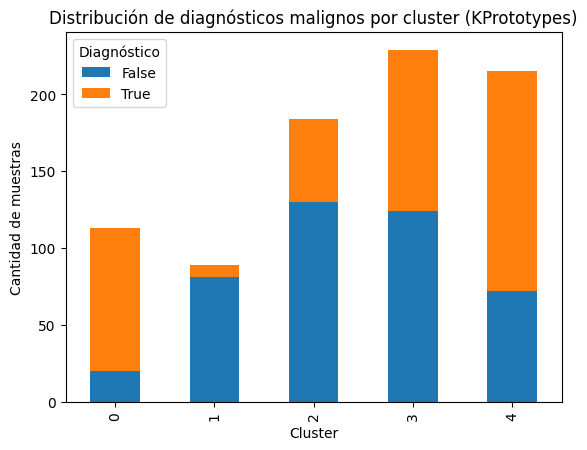

In [96]:
# Contamos el número de diagnósticos malignos por clúster
print("Malignant counts by cluster:")
print(df_kprototypes_eval.groupby(['Cluster', 'Malignant']).size().unstack(fill_value=0))

# Agrupamos por número de clúster y calcular la proporción de casos malignos en cada clúster.
malignant_proportions = df_kprototypes_eval.groupby('Cluster')['Malignant'].mean()

# Imprimimos las proporciones de casos malignos por clúster.
print("Proporciones de casos malignos por cluster:")
print(malignant_proportions)

# Histogramas de los clústeres por diagnóstico.
plt.figure(figsize=(10, 6))
df_kprototypes_eval.groupby(['Cluster', 'Malignant']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Distribución de diagnósticos malignos por cluster (KPrototypes)')
plt.xlabel('Cluster')
plt.ylabel('Cantidad de muestras')
plt.legend(title='Diagnóstico')
plt.show()

En general, este algoritmo, con nuestros datos no consigue la segregación de las características de manera satisfactoria. Se observó un solapamiento de las características en todos lo grupos, e incluso, evaluando los clústeres con el diagnostico de las observaciones, solo se observaron dos clústeres, 0 y 1, en los que los diagnósticos se distribuían mayoritariamente en malignos o benignos, respectivamente. Los demás clústeres muestran una variabilidad alta en la que no se puede determinar significativamente si se agrupan en características benignas o malignas.

# Modelos con matriz de distancia Gower

### K-Medoids (Gower)

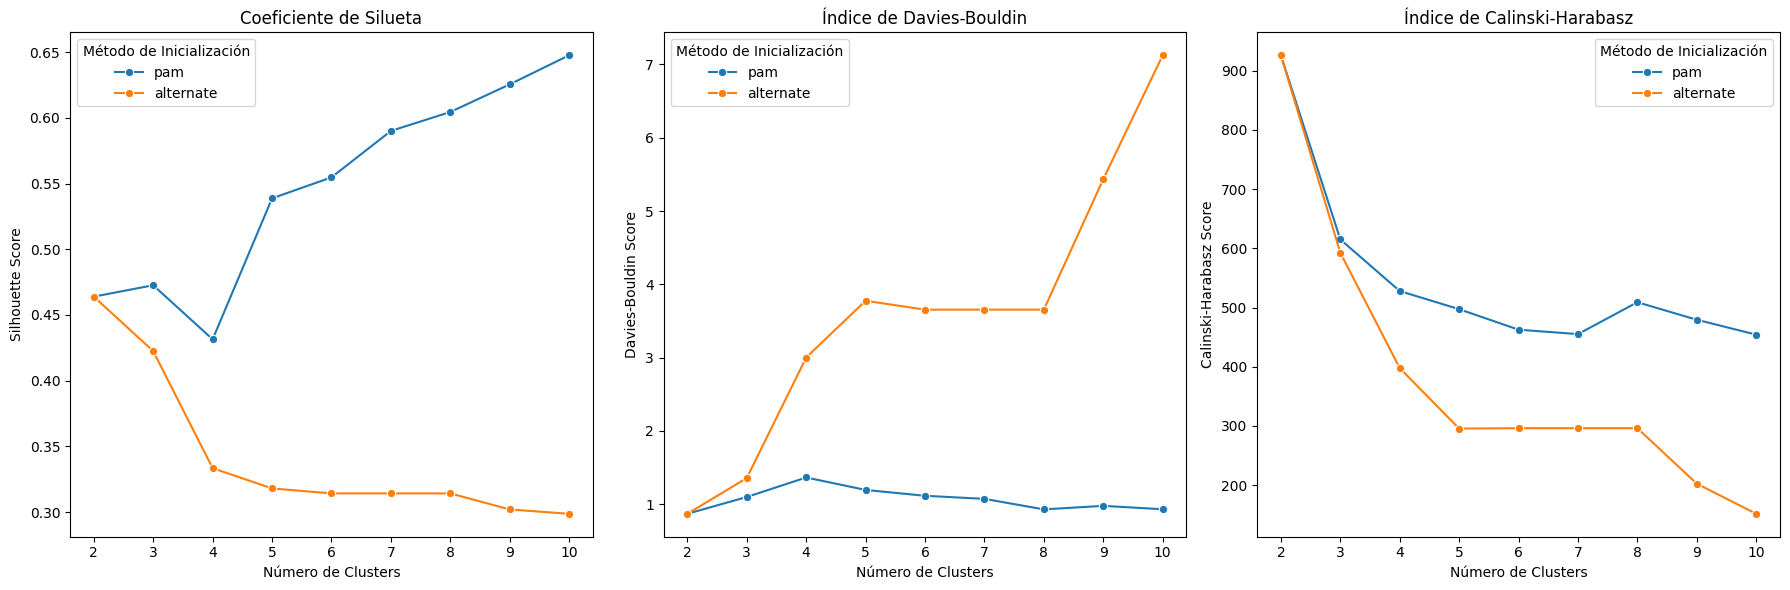

In [49]:
# Establecemos rangos de clusters y métodos de inicialización
n_clusters_range = range(2, 11)
init_methods = ['pam', 'alternate']

# Listas para almacenar las métricas de evaluación
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

# Aplicamos el modelo K-Medoids:
for n_clusters in n_clusters_range:
    for init_method in init_methods:
        kmedoids_model = KMedoids(n_clusters=n_clusters, method=init_method, metric='precomputed', random_state=42)
        kmedoids_clusters = kmedoids_model.fit_predict(gower_dist)
        
        # Calcular métricas de evaluación
        silhouette_avg = silhouette_score(gower_dist, kmedoids_clusters, metric='precomputed')
        silhouette_scores.append((n_clusters, init_method, silhouette_avg))
        
        davies_bouldin_avg = davies_bouldin_score(gower_dist, kmedoids_clusters)
        davies_bouldin_scores.append((n_clusters, init_method, davies_bouldin_avg))
        
        calinski_harabasz_avg = calinski_harabasz_score(gower_dist, kmedoids_clusters)
        calinski_harabasz_scores.append((n_clusters, init_method, calinski_harabasz_avg))

# Guardamos los resultados a DataFrames
silhouette_df = pd.DataFrame(silhouette_scores, columns=['Clusters', 'Método de Inicialización', 'Coeficiente de Silueta'])
davies_bouldin_df = pd.DataFrame(davies_bouldin_scores, columns=['Clusters', 'Método de Inicialización', 'Davies-Bouldin Score'])
calinski_harabasz_df = pd.DataFrame(calinski_harabasz_scores, columns=['Clusters', 'Método de Inicialización', 'Índice de Calinski-Harabasz'])

# Graficas
plt.figure(figsize=(18, 6))

# Silhouette Score
plt.subplot(1, 3, 1)
sns.lineplot(data=silhouette_df, x='Clusters', y='Coeficiente de Silueta', hue='Método de Inicialización', marker='o')
plt.title('Coeficiente de Silueta')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')

# Davies-Bouldin Score
plt.subplot(1, 3, 2)
sns.lineplot(data=davies_bouldin_df, x='Clusters', y='Davies-Bouldin Score', hue='Método de Inicialización', marker='o')
plt.title('Índice de Davies-Bouldin')
plt.xlabel('Número de Clusters')
plt.ylabel('Davies-Bouldin Score')

# Calinski-Harabasz Score
plt.subplot(1, 3, 3)
sns.lineplot(data=calinski_harabasz_df, x='Clusters', y='Índice de Calinski-Harabasz', hue='Método de Inicialización', marker='o')
plt.title('Índice de Calinski-Harabasz')
plt.xlabel('Número de Clusters')
plt.ylabel('Calinski-Harabasz Score')

plt.tight_layout()
plt.show()

El algoritmo K-Medoids nos permitió utilizar matrices de distancia precomputadas, y haciendo uso de la matriz de Gower, que permite trabajar con variables categóricas y continuas a la vez, se implementó este modelo. Igual que en los anteriores modelos se calculó los índices de validación en un rango de clústeres (de 2 a 10) con distintos métodos de iniciación (“pam” y “alternate”) 

In [98]:
# Modelo KMedoids con los parametros seleccionados: 
kmedoids_model = KMedoids(n_clusters=2, method='pam', random_state=42)
kmedoids_clusters = kmedoids_model.fit_predict(gower_dist)

# índice de Davies-Bouldin
db_index = davies_bouldin_score(gower_dist, kmedoids_clusters)

# índice de Calinski-Harabasz
ch_index = calinski_harabasz_score(gower_dist, kmedoids_clusters)

# coeficiente de silueta
silhouette_avg = silhouette_score(gower_dist, kmedoids_clusters)

# Mostramos los resultados:
print("Índice de Davies-Bouldin:", db_index)
print("Índice de Calinski-Harabasz:", ch_index)
print("Coeficiente de Silueta:", silhouette_avg)

Índice de Davies-Bouldin: 0.8703669239947233
Índice de Calinski-Harabasz: 936.7115271865513
Coeficiente de Silueta: 0.4909322


      age shape margin density  Cluster  Malignant
0    45.0   2.0    4.0     3.0        0      False
1    69.0   4.0    5.0     3.0        0       True
2    58.0   4.0    4.0     3.0        0      False
3    72.0   4.0    3.0     3.0        0       True
4    71.0   4.0    4.0     3.0        0       True
..    ...   ...    ...     ...      ...        ...
954  80.0   4.0    5.0     3.0        0       True
955  51.0   4.0    4.0     3.0        0       True
956  71.0   4.0    4.0     3.0        0       True
957  68.0   4.0    3.0     3.0        0       True
958  72.0   4.0    3.0     3.0        0       True

[830 rows x 6 columns]


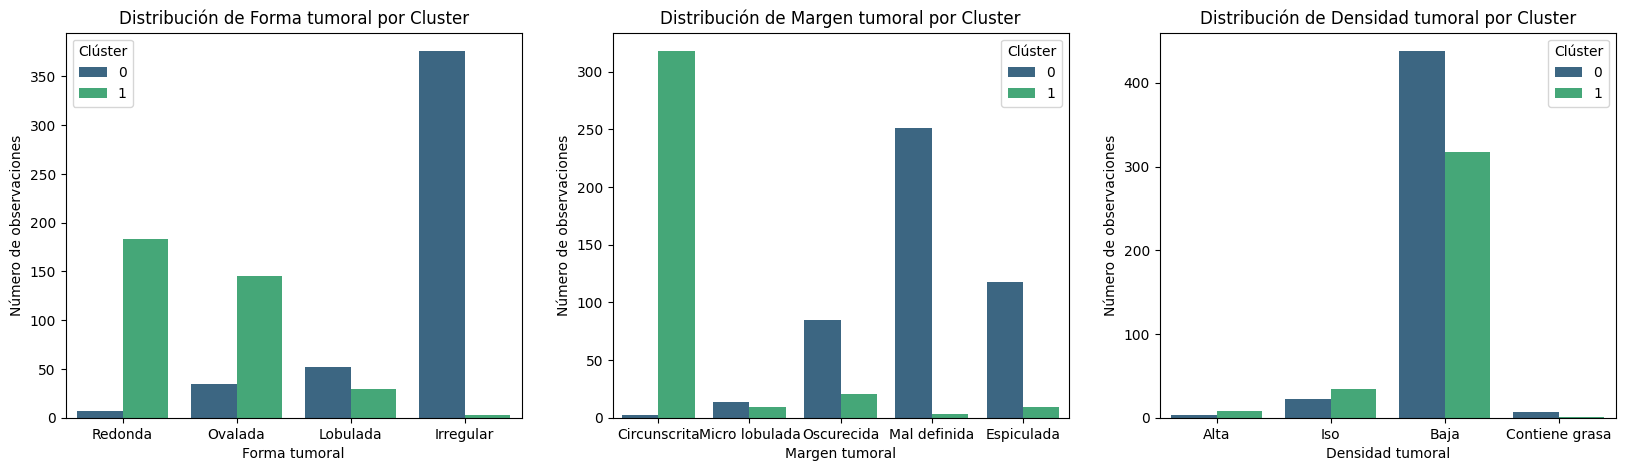

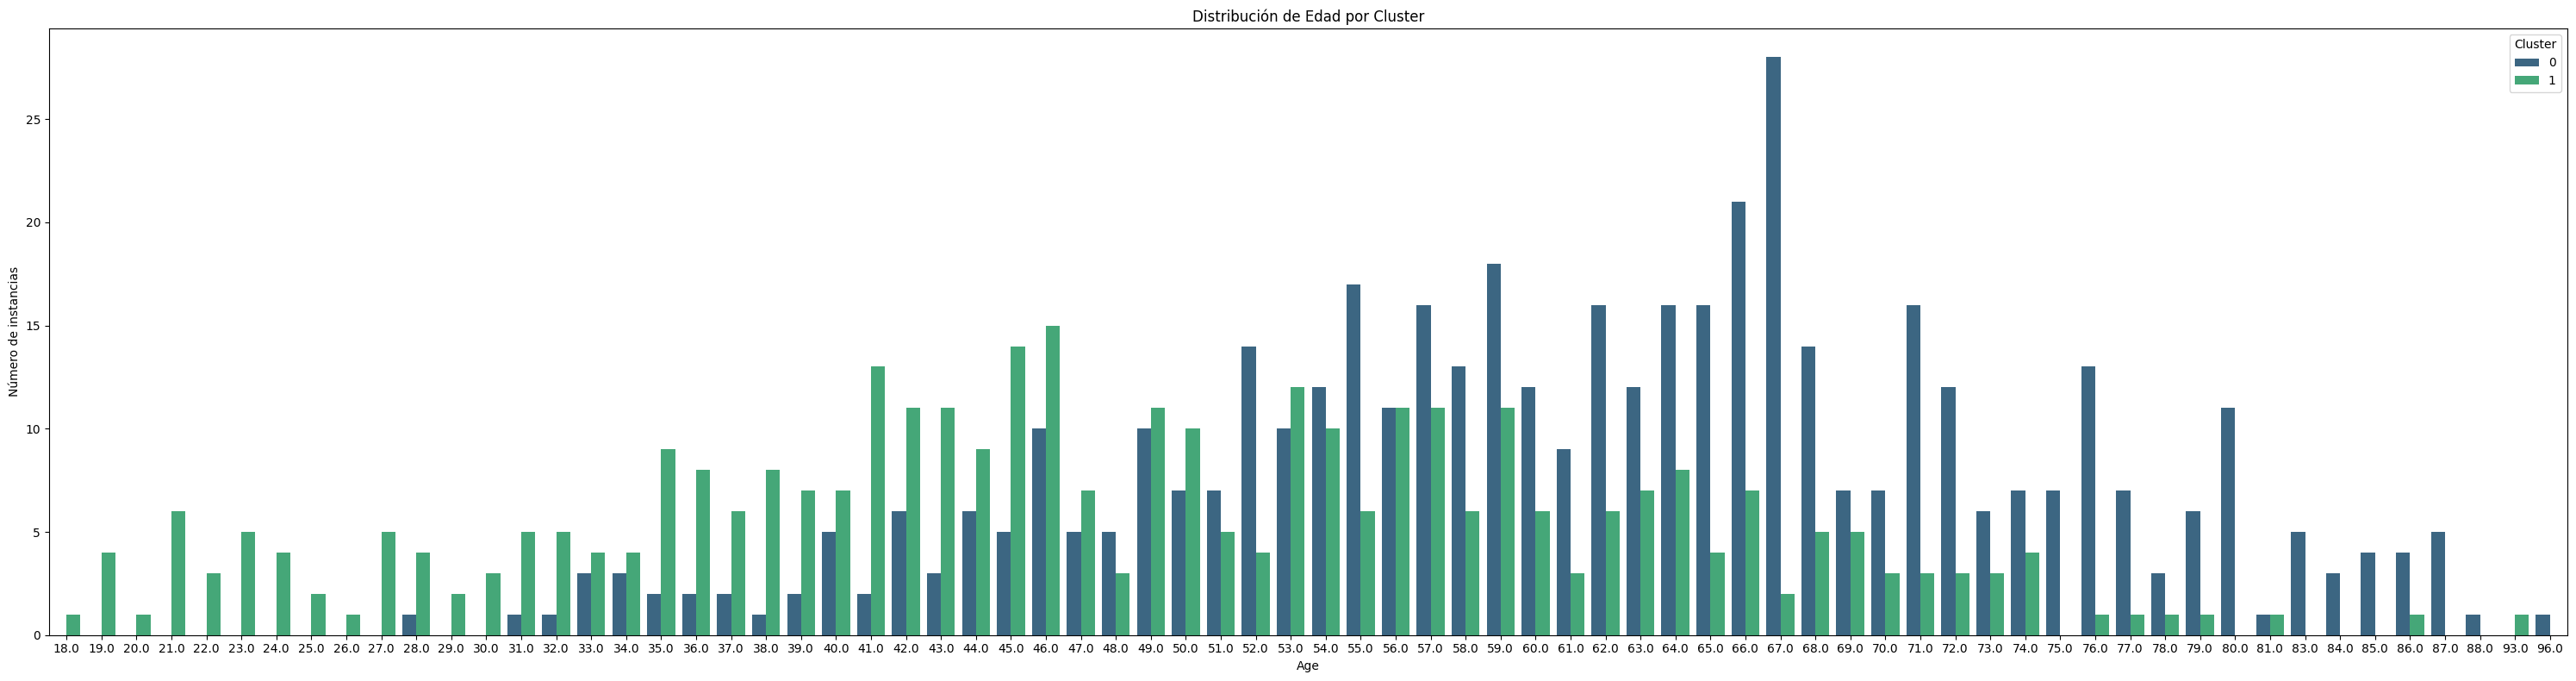

In [100]:
df_kmedoids_eval = df_models.copy()

# Introducimos los clústeres y la variables diagnósis al dataframe de evaluación:
df_kmedoids_eval['Cluster'] = kmedoids_clusters
df_kmedoids_eval['Malignant'] = malignant_diagnosis
print(df_kmedoids_eval)

# Mapeos de las categorías
shape_mapping = {1: 'Redonda', 2: 'Ovalada', 3: 'Lobulada', 4: 'Irregular'}
margin_mapping = {1: 'Circunscrita', 2: 'Micro lobulada', 3: 'Oscurecida', 4: 'Mal definida', 5: 'Espiculada'}
density_mapping = {1: 'Alta', 2: 'Iso', 3: 'Baja', 4: 'Contiene grasa'}

# mapear etiquetas
def map_labels(labels, mapping):
    mapped_labels = []
    for label in labels:
        try:
            int_label = int(float(label.get_text())) 
            mapped_labels.append(mapping.get(int_label, label.get_text()))
        except ValueError:
            mapped_labels.append(label.get_text())  
    return mapped_labels

# Figuras 
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Distribución de 'Shape' por cluster
sns.countplot(x='shape', hue='Cluster', data=df_kmedoids_eval, palette='viridis', ax=axs[0])
axs[0].set_title('Distribución de Forma tumoral por Cluster')
axs[0].set_xlabel('Forma tumoral')
axs[0].set_ylabel('Número de observaciones')
axs[0].legend(title='Clúster')
axs[0].set_xticklabels(map_labels(axs[0].get_xticklabels(), shape_mapping))

# Distribución de 'Margin' por cluster
sns.countplot(x='margin', hue='Cluster', data=df_kmedoids_eval, palette='viridis', ax=axs[1])
axs[1].set_title('Distribución de Margen tumoral por Cluster')
axs[1].set_xlabel('Margen tumoral')
axs[1].set_ylabel('Número de observaciones')
axs[1].legend(title='Clúster')
axs[1].set_xticklabels(map_labels(axs[1].get_xticklabels(), margin_mapping))

# Distribución de 'Density' por cluster
sns.countplot(x='density', hue='Cluster', data=df_kmedoids_eval, palette='viridis', ax=axs[2])
axs[2].set_title('Distribución de Densidad tumoral por Cluster')
axs[2].set_xlabel('Densidad tumoral')
axs[2].set_ylabel('Número de observaciones')
axs[2].legend(title='Clúster')
axs[2].set_xticklabels(map_labels(axs[2].get_xticklabels(), density_mapping))


plt.figure(figsize=(30, 8))
ax = plt.axes()

# Gráfico de distribución de 'Age' por cluster
sns.countplot(x='age', hue='Cluster', data=df_kmedoids_eval, palette='viridis', ax=ax)
ax.set_title('Distribución de Edad por Cluster')
ax.set_xlabel('Age')
ax.set_ylabel('Número de instancias')
ax.legend(title='Cluster')


plt.tight_layout()
plt.show()

Se estableció el número de clúster a 2, donde los valores de los índices mostraban una cohesión y segregación aceptables, además de por la fácil interpretación visual de las características tumorales. Valores más altos en el número de clústeres diluían demasiado la segregación de las características y empeoraban los índices de evaluación. La distribución de las características en los clústeres, aunque muestran solapamiento en ambos grupos, se denota una tendencia del grupo 0 a agrupar características de formas irregulares y con márgenes micro lobulados, oscurecidos, mal definidos y espiculados, además de un contenido en grasa bajo, que comparte con el grupo 1. Estás características como se ha observado en otros modelos están relacionadas con lesiones tumorales malignas. El clúster 1, por el contrario, concentra características de forma regular y bien definidas o circunscritas comúnmente asociadas a lesiones tumorales benignas. También, en este algoritmo, vemos como se distribuyen los grupos según la edad, se observó que la incidencia de lesiones relativas al clúster 0 va creciendo desde edades cercanas a 30 años hasta alcanzar el número máximo de observaciones sobre los 67 años. En edades inferiores a 27 años, solo está presente el clúster 1. Esta observación parece coherente ya que la edad juega un papel importante en el riesgo de padecer una afección maligna (Kroenke et al., 2004), y el cluster 0 muestra características relacionas con características de índole maligno. Cabe destacar que el clúster 1 está presente casi todas las edades.



Malignant counts by cluster:
Malignant  False  True 
Cluster                
0            119    351
1            308     52
Proporciones de casos malignos por cluster:
Cluster
0    0.746809
1    0.144444
Name: Malignant, dtype: float64


<Figure size 1000x600 with 0 Axes>

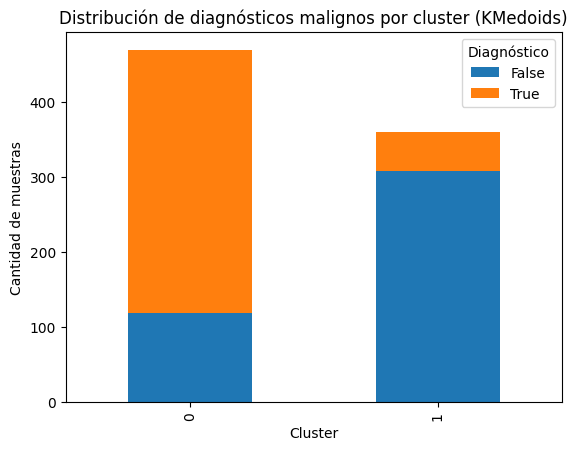

In [52]:
# Contamos el número de diagnósticos malignos por clúster
print("Malignant counts by cluster:")
print(df_kmedoids_eval.groupby(['Cluster', 'Malignant']).size().unstack(fill_value=0))

# Agrupamos por número de clúster y calcular la proporción de casos malignos en cada clúster.
malignant_proportions = df_kmedoids_eval.groupby('Cluster')['Malignant'].mean()

# Imprimimos las proporciones de casos malignos por clúster.
print("Proporciones de casos malignos por cluster:")
print(malignant_proportions)

# Histogramas de los clústeres por diagnóstico.
plt.figure(figsize=(10, 6))
df_kmedoids_eval.groupby(['Cluster', 'Malignant']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Distribución de diagnósticos malignos por cluster (KMedoids)')
plt.xlabel('Cluster')
plt.ylabel('Cantidad de muestras')
plt.legend(title='Diagnóstico')
plt.show()

Evaluando los clústeres obtenidos con los diagnósticos de las observaciones, obtuvimos que de las observaciones del clúster 0, un 75% fueron de carácter maligno. De las observaciones del cluster 1, el 14% fueron de carácter maligno. 

### Hierarchical clustering (Gower)

Hierarchical Clustering es un enfoque de clustering que crea una jerarquía de grupos en función de la similitud entre las observaciones. En lugar de asignar directamente las observaciones a un número fijo de clústeres como en los métodos de clustering particionales (como K-Means), el clustering jerárquico construye un árbol jerárquico de clústeres.

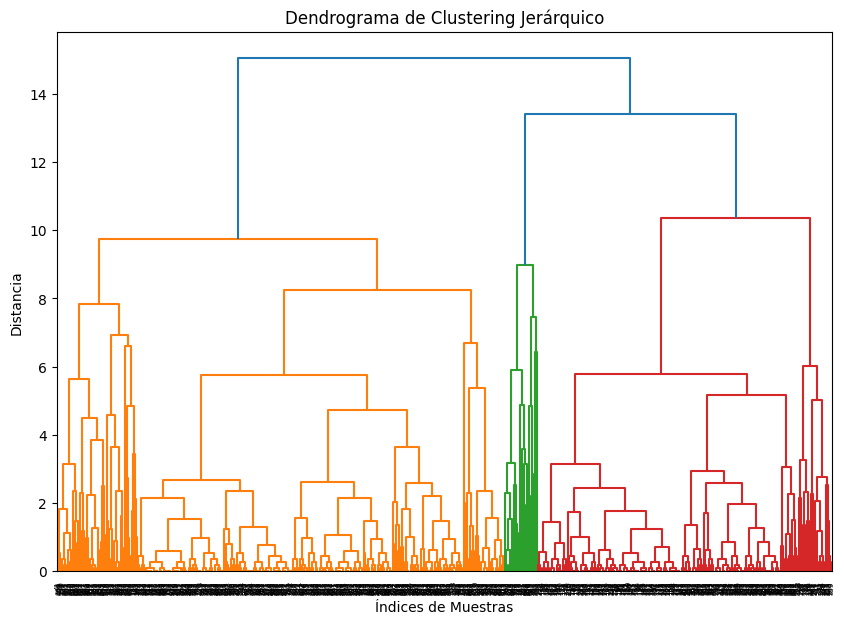

In [38]:
# Implementamos el clúster jerarquico aglomerativo con el metodo 'complete'
Z = linkage(gower_dist, method='complete')

# Calculamos el dendrograma
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=df.index.tolist())
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Índices de Muestras')
plt.ylabel('Distancia')
plt.show()

In [105]:
# Establecemos el umbral para determinar el número de clústeres
threshold = 9

# Establecemos el número de fusiones por encima del umbral
num_clusters = len(Z[Z[:, 2] > threshold])
print("Número de clústeres sugerido:", num_clusters)

# Obtenemos las etiquetas de los clústeres
num_clusters = 4
cluster_labels = fcluster(Z, num_clusters, criterion='maxclust')

# índice de Davies-Bouldin
db_index = davies_bouldin_score(gower_dist, cluster_labels)

# índice de Calinski-Harabasz
ch_index = calinski_harabasz_score(gower_dist, cluster_labels)

# coeficiente de silueta
silhouette_avg = silhouette_score(gower_dist, cluster_labels)

# Mostramos los resultados
print("Índice de Davies-Bouldin:", db_index)
print("Índice de Calinski-Harabasz:", ch_index)
print("Coeficiente de Silueta:", silhouette_avg)

Número de clústeres sugerido: 4
Índice de Davies-Bouldin: 0.9119761685422234
Índice de Calinski-Harabasz: 486.35803530570405
Coeficiente de Silueta: 0.46458587


El último algoritmo implementado es la agrupación jerárquica aglomerativo haciendo uso de la matriz de distancias Gower. Con la matriz de distancia precomputada se implementó el algoritmo jerárquico con el método “complete” estableciendo la distancia máxima, es decir, la distancia entre dos clústeres se define como la distancia máxima entre cualquier par de puntos, uno de cada clúster.
Se estableció el umbral de corte a una distancia de 9 en el dendrograma, lo que proporciono un número sugerido de 4 clústeres. Estableciendo el número de clúster a un valor inferior o superior empeoraba los incides de evaluación, con lo que establecimos el número óptimo de 4 clústeres para este modelo.

      age shape margin density  Cluster  Malignant
0    45.0   2.0    4.0     3.0        1      False
1    69.0   4.0    5.0     3.0        1       True
2    58.0   4.0    4.0     3.0        1      False
3    72.0   4.0    3.0     3.0        1       True
4    71.0   4.0    4.0     3.0        1       True
..    ...   ...    ...     ...      ...        ...
954  80.0   4.0    5.0     3.0        1       True
955  51.0   4.0    4.0     3.0        1       True
956  71.0   4.0    4.0     3.0        1       True
957  68.0   4.0    3.0     3.0        1       True
958  72.0   4.0    3.0     3.0        1       True

[830 rows x 6 columns]


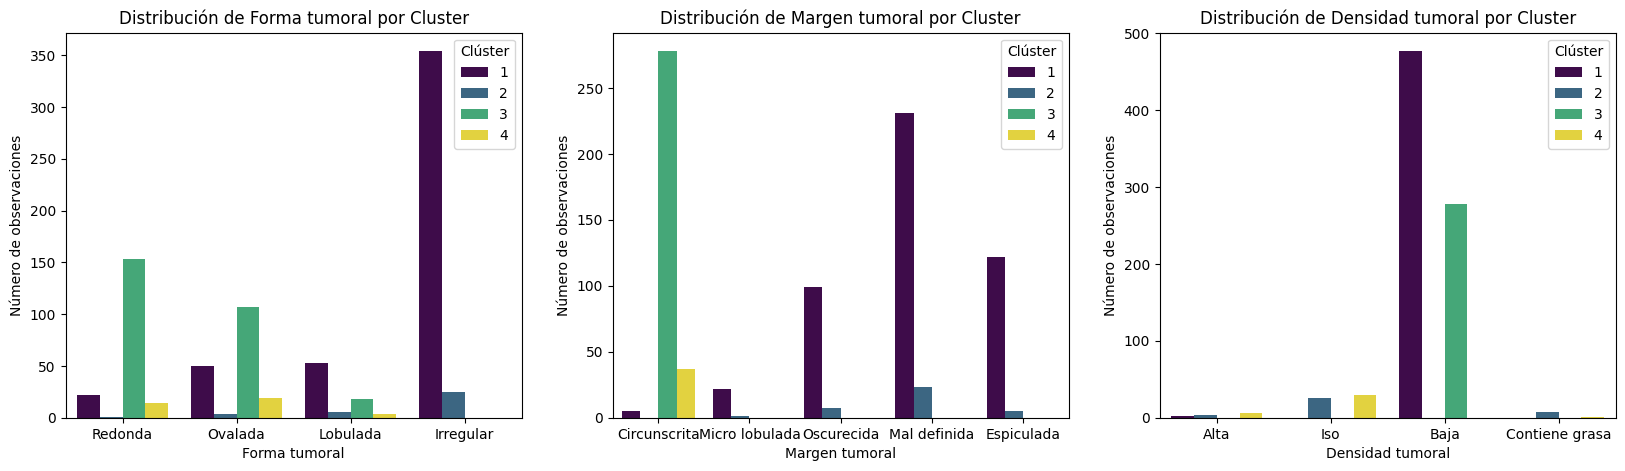

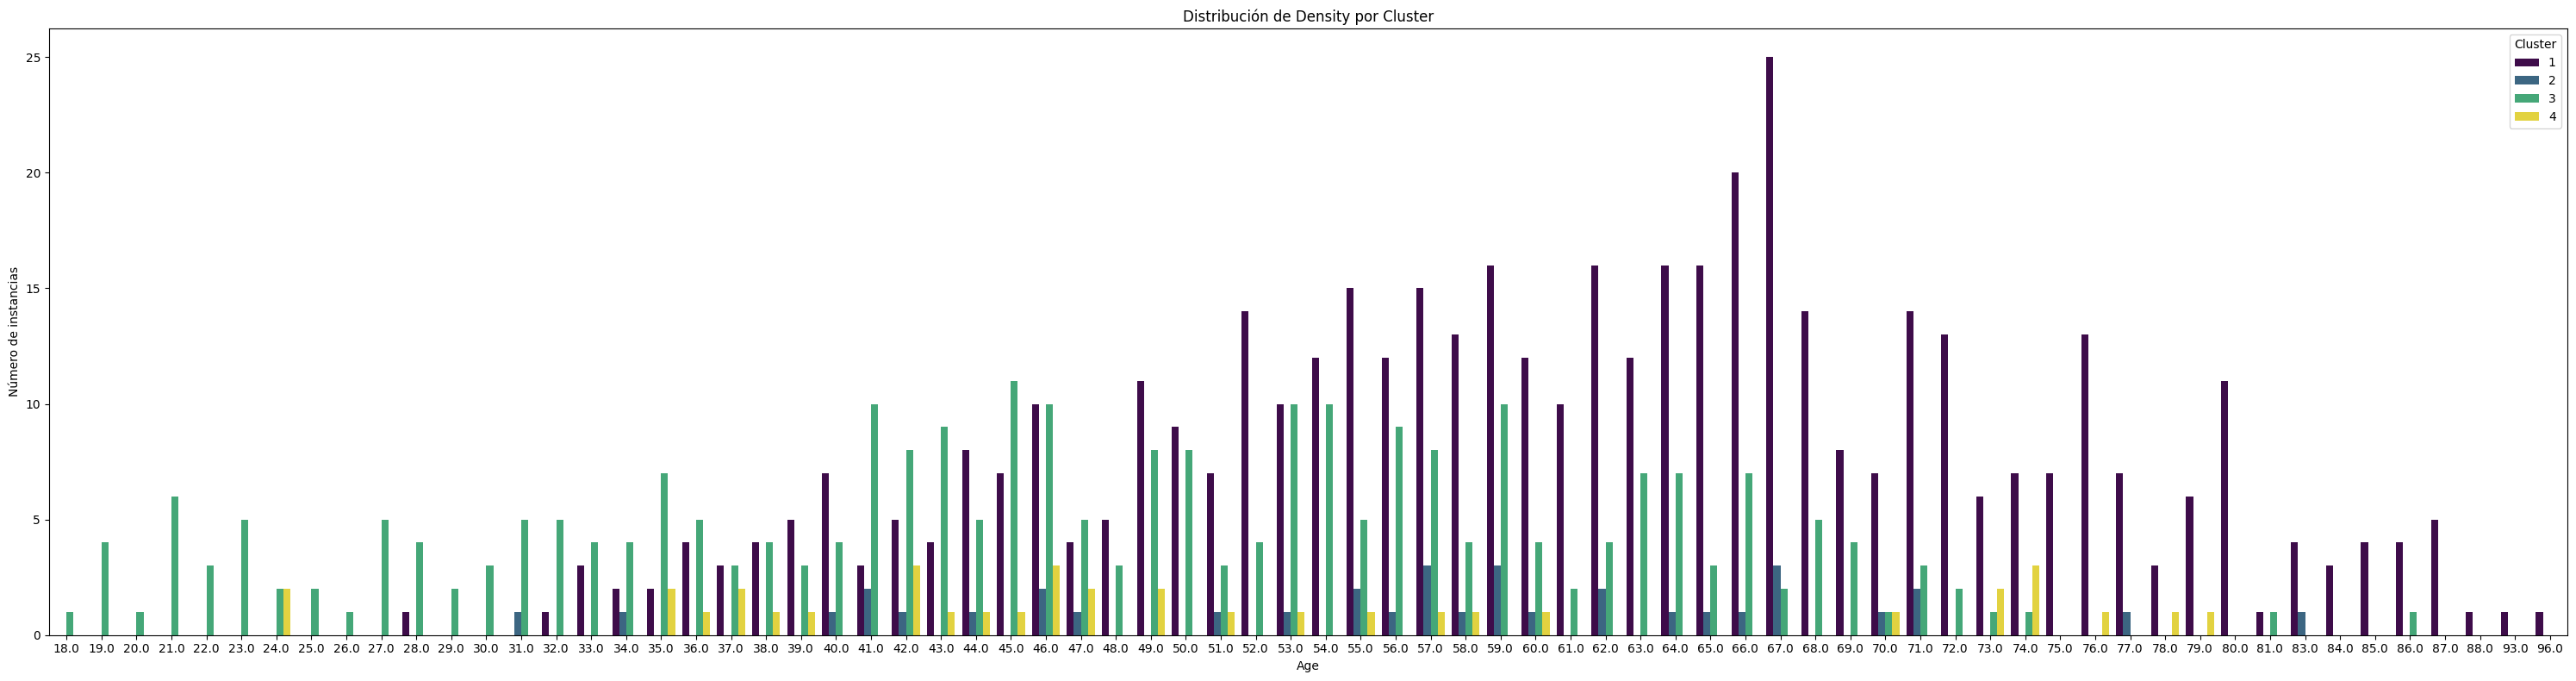

In [106]:
df_eval_hc = df_models.copy()

# Añadimos los clústeres y la variables diagnósis al dataframe de evaluación:
df_eval_hc['Cluster'] = cluster_labels
df_eval_hc['Malignant'] = malignant_diagnosis

# Mostramos el dataframe
print(df_eval_hc)

# Mapeos de las categorías
shape_mapping = {1: 'Redonda', 2: 'Ovalada', 3: 'Lobulada', 4: 'Irregular'}
margin_mapping = {1: 'Circunscrita', 2: 'Micro lobulada', 3: 'Oscurecida', 4: 'Mal definida', 5: 'Espiculada'}
density_mapping = {1: 'Alta', 2: 'Iso', 3: 'Baja', 4: 'Contiene grasa'}

# mapear etiquetas
def map_labels(labels, mapping):
    mapped_labels = []
    for label in labels:
        try:
            int_label = int(float(label.get_text())) 
            mapped_labels.append(mapping.get(int_label, label.get_text()))
        except ValueError:
            mapped_labels.append(label.get_text()) 
    return mapped_labels

# Figuras
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Distribución de 'Shape' por cluster
sns.countplot(x='shape', hue='Cluster', data=df_eval_hc, palette='viridis', ax=axs[0])
axs[0].set_title('Distribución de Forma tumoral por Cluster')
axs[0].set_xlabel('Forma tumoral')
axs[0].set_ylabel('Número de observaciones')
axs[0].legend(title='Clúster')
axs[0].set_xticklabels(map_labels(axs[0].get_xticklabels(), shape_mapping))

# Distribución de 'Margin' por cluster
sns.countplot(x='margin', hue='Cluster', data=df_eval_hc, palette='viridis', ax=axs[1])
axs[1].set_title('Distribución de Margen tumoral por Cluster')
axs[1].set_xlabel('Margen tumoral')
axs[1].set_ylabel('Número de observaciones')
axs[1].legend(title='Clúster')
axs[1].set_xticklabels(map_labels(axs[1].get_xticklabels(), margin_mapping))

# Distribución de 'Density' por cluster
sns.countplot(x='density', hue='Cluster', data=df_eval_hc, palette='viridis', ax=axs[2])
axs[2].set_title('Distribución de Densidad tumoral por Cluster')
axs[2].set_xlabel('Densidad tumoral')
axs[2].set_ylabel('Número de observaciones')
axs[2].legend(title='Clúster')
axs[2].set_xticklabels(map_labels(axs[2].get_xticklabels(), density_mapping))

plt.figure(figsize=(30, 8)) 
ax = plt.axes()

# Gráfico de distribución de 'Age' por cluster
sns.countplot(x='age', hue='Cluster', data=df_eval_hc, palette='viridis', ax=ax)
ax.set_title('Distribución de Density por Cluster')
ax.set_xlabel('Age')
ax.set_ylabel('Número de instancias')
ax.legend(title='Cluster')


plt.tight_layout()
plt.show()

En la distribución de las características tumorales para estos clústeresse observó que el clúster 1 esta presenta en menor o mayor medida en todas las observaciones de las características de forma y margen tumoral, aunque están más representado por observaciones con formas irregulares y márgenes mal definidos, de cara a la densidad, se concentra en la característica de densidad baja. El clúster 2 tiene una representación muy baja, es decir, no contiene muchas observaciones, y se concentra en la forma irregular y márgenes mal definidas, así como con la densidad iso. El clúster 3, esta caracterizado por contener observaciones con características definidas, formas redondeadas (redondas, ovaladas y lobuladas) y densidades bajas. Por último, el cluster 4, también con pocas observaciones, está representado por características definidas y esféricas, además de densidades altas e iso. 
También se observó la distribución de los clústeres por edad, donde los clústeres 1 y 3 son los más representados, mientras que los clústeres 2 y 4 están menos representados y acotadas a edades comprendidas entre los 30 y 80 años. El clúster 1 empieza a tener representación a los 28 años hasta los 98 años, y el clúster 3 se concentra a edades más tempranas. 
Estas observaciones casan con los resultados obtenidos en otros modelos, y siguen la misma justificación, la incidencia de tumores malignos se asocia a características en la forma irregular y márgenes poco definidos, además de aumentar con la edad. 


Malignant counts by cluster:
Malignant  False  True 
Cluster                
1            135    344
2             13     23
3            245     33
4             34      3
Proporciones de casos malignos por cluster:
Cluster
1    0.718163
2    0.638889
3    0.118705
4    0.081081
Name: Malignant, dtype: float64


<Figure size 1000x600 with 0 Axes>

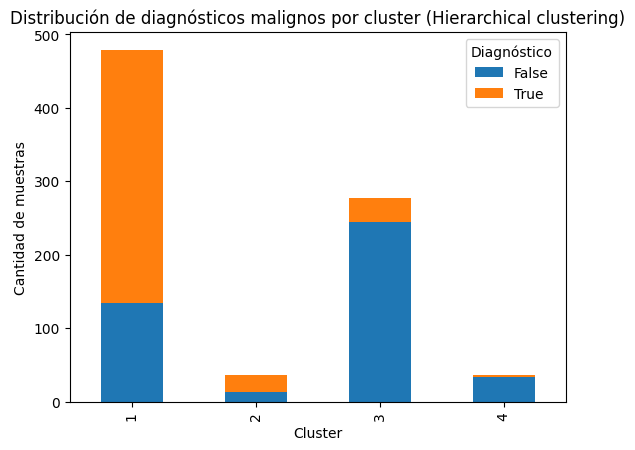

In [55]:
# Contamos el número de diagnósticos malignos por clúster
print("Malignant counts by cluster:")
print(df_eval_hc.groupby(['Cluster', 'Malignant']).size().unstack(fill_value=0))

# Agrupamos por número de clúster y calcular la proporción de casos malignos en cada clúster.
malignant_proportions = df_eval_hc.groupby('Cluster')['Malignant'].mean()

# Imprimimos las proporciones de casos malignos por clúster.
print("Proporciones de casos malignos por cluster:")
print(malignant_proportions)

# Histogramas de los clústeres por diagnóstico.
plt.figure(figsize=(10, 6))
df_eval_hc.groupby(['Cluster', 'Malignant']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Distribución de diagnósticos malignos por cluster (Hierarchical clustering)')
plt.xlabel('Cluster')
plt.ylabel('Cantidad de muestras')
plt.legend(title='Diagnóstico')
plt.show()

La evaluación mostró dos grupos con una incidencia de casos malignos menor al 15%, clústeres 3 y 4, mientras que los clústeres 1 y 2 mostraron una incidencia mayor al 50%. 

# Referencias

1. Elter, M., Schulz-Wendtland, R., & Wittenberg, T. (2007). The prediction of breast cancer biopsy outcomes using two CAD approaches that both emphasize an intelligible decision process. Medical physics, 34(11), 4164-4172.
2. Spak, D. A., Plaxco, J. S., Santiago, L., Dryden, M. J., & Dogan, B. E. (2017). BI-RADS® fifth edition: A summary of changes. Diagnostic and interventional imaging, 98(3), 179-190.
3. Orel, S. G., Kay, N., Reynolds, C., & Sullivan, D. C. (1999). BI-RADS categorization as a predictor of malignancy. Radiology, 211(3), 845-850.
4. Boyd, N. F., Guo, H., Martin, L. J., et al. (2007). Mammographic Density and the Risk and Detection of Breast Cancer. The New England Journal of Medicine, 356(3), 227-236.
5. Edwards, B. K., Noone, A. M., Mariotto, A. B., et al. (2014). Annual Report to the Nation on the Status of Cancer, 1975–2011, Featuring Incidence of Breast Cancer Subtypes by Race/Ethnicity, Poverty, and State. Journal of the National Cancer Institute.
6. Gower, J. C. (1971). A general coefficient of similarity and some of its properties. Biometrics, 857-871.
7. Kroenke, C. H., Rosner, B., Chen, W. Y., Kawachi, I., Colditz, G. A., & Holmes, M. D. (2004). Functional impact of breast cancer by age at diagnosis. Journal of Clinical Oncology, 22(10), 1849-1856.


"Resto de bibliografia incluido en la memoria del proyecto"